<a href="https://colab.research.google.com/github/Palaeoprot/IPA/blob/main/Skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
#@title #Import Libraries and Setup
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import math
import json
import gspread
from datetime import datetime
import random
from scipy.optimize import differential_evolution, curve_fit
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import logging
from typing import List, Dict, Tuple
import configparser
import argparse

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2024-07-05 18:44:52.886585 - INFO - Data loaded successfully from Google Sheet
2024-07-05 18:44:52.903117 - INFO - Processing eggshell data
2024-07-05 18:44:53.260357 - INFO - Eggshell data processed successfully
2024-07-05 18:44:54.467907 - INFO - Optimized parameters: {'k_hydrolysis': 0.00031707713283796505, 'k_racemization_int': 0.0003073025217726991, 'k_racemization_term': 0.0003160327551704855, 'k_racemization_free': 0.0004019811821682854, 'k_loss': 9.693002776115209e-08, 'k_water_generation': 9.696612007623504e-09}


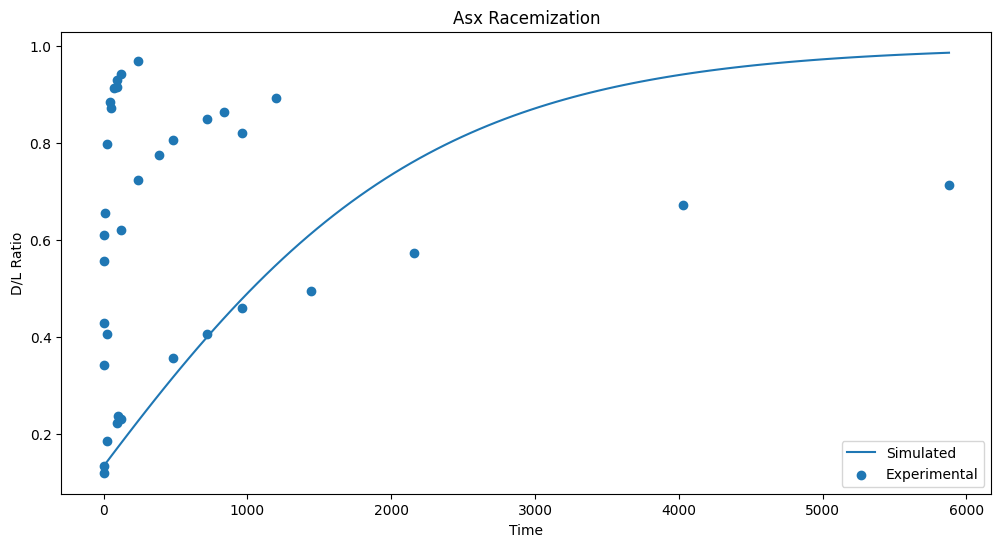

In [38]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class ModulAAR:
    def __init__(self, config):
        self.config = config
        self.data = None
        self.processed_data = None
        self.logger = self._setup_logger()

    def _setup_logger(self):
        from datetime import datetime
        return lambda msg, level="INFO": print(f"{datetime.now()} - {level} - {msg}")

    def load_data(self, source=None, is_gsheet=False, filepath=None):
        """Load data from a file, CSV, or Google Sheets."""
        try:
            if is_gsheet and source:
                sheet_id = source['sheet_id']
                gid = source['gid']
                export_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"
                self.data = pd.read_csv(export_url)
                self.logger(f"Data loaded successfully from Google Sheet")
            elif filepath:
                self.data = pd.read_csv(filepath)
                self.logger(f"Data loaded successfully from file: {filepath}")
            else:
                self.data = pd.read_csv(source)
                self.logger(f"Data loaded successfully from {source}")
        except Exception as e:
            self.logger(f"Error loading data: {str(e)}", "ERROR")
            self.data = None
        return self.data

    def process_data(self, df=None):
        """Process the loaded data based on its type."""
        if df is None:
            df = self.data
        if df is None:
            self.logger("No data available for processing.", "ERROR")
            return None

        df = df.dropna()

        # Flexible column renaming
        rename_mapping = {
            'time (h)': 'time',
            'temp': 'temp (°C)',
            'Pre-heat bleach time': 'Pre-heat bleach time (h)'
            # Add other potential column mappings here if needed
        }
        df = df.rename(columns=rename_mapping)

        expected_eggshell_columns = [
            'Pre-heat bleach time (h)', 'temp (°C)', 'pH', 'sample', 'time',
            '[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]',
            'Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L'
        ]
        expected_betalactoglobulin_columns = ['Condition', 'Fraction', 'm']

        if all(col in df.columns for col in expected_eggshell_columns):
            self.logger("Processing eggshell data")
            return self._process_eggshell_data(df)
        elif all(col in df.columns for col in expected_betalactoglobulin_columns):
            self.logger("Processing beta-lactoglobulin data")
            return self._process_betalactoglobulin_data(df)
        else:
            self.logger(
                f"Unknown data format. Expected columns for eggshell: {expected_eggshell_columns}, "
                f"or beta-lactoglobulin: {expected_betalactoglobulin_columns}. Found columns: {list(df.columns)}",
                "ERROR"
            )
            return None

    def _process_eggshell_data(self, df):
        """Process eggshell data."""
        df = self.clean_data(df)
        grouped_faa, grouped_thaa = self.calculate_stats(df)

        processed_df = pd.merge(grouped_faa, grouped_thaa, on=['temp (°C)', 'time'], how='outer')

        # Add 'temp (K)' column
        if 'temp (°C)' in processed_df.columns:
            processed_df.loc[:, 'temp (K)'] = processed_df['temp (°C)'] + 273.15

        self.logger("Eggshell data processed successfully")
        return processed_df

    def _process_betalactoglobulin_data(self, df):
        """Process beta-lactoglobulin data."""
        relevant_columns = ['Condition', 'Fraction', 'm', '[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]',
                            'Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L']
        df = df[relevant_columns]

        # Convert concentration and D/L columns to numeric
        for col in relevant_columns:
            if col.startswith('[') or col.endswith('D/L'):
                df.loc[:, col] = pd.to_numeric(df[col], errors='coerce')

        # Group by condition and calculate statistics
        grouped = df.groupby(['Condition', 'Fraction', 'm']).agg({
            col: ['mean', 'std'] for col in relevant_columns if col not in ['Condition', 'Fraction', 'm']
        }).reset_index()

        # Flatten column names
        grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

        self.logger("Beta-lactoglobulin data processed successfully")
        return grouped

    def clean_data(self, df):
        """Clean the eggshell data by converting to numeric and filtering."""
        concentration_columns = ['[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]']
        dl_columns = ['Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L']

        for col in concentration_columns + dl_columns:
            df.loc[:, col] = pd.to_numeric(df[col], errors='coerce')

        df = df.dropna(subset=concentration_columns + dl_columns)
        return df

    def calculate_stats(self, df):
        """Calculate statistics for FAA and THAA samples."""
        faa_df = df[df['sample'] == 'FAA']
        thaa_df = df[df['sample'] == 'THAA']

        grouped_faa = faa_df.groupby(['temp (°C)', 'time']).agg({
            '[Asx]': ['mean', 'std', 'count'],
            '[Glx]': ['mean', 'std', 'count'],
            '[Ser]': ['mean', 'std', 'count'],
            '[Ala]': ['mean', 'std', 'count'],
            '[Val]': ['mean', 'std', 'count'],
            '[Phe]': ['mean', 'std', 'count'],
            '[Ile]': ['mean', 'std', 'count'],
            'Asx D/L': ['mean', 'std', 'count'],
            'Glx D/L': ['mean', 'std', 'count'],
            'Ser D/L': ['mean', 'std', 'count'],
            'Ala D/L': ['mean', 'std', 'count'],
            'Val D/L': ['mean', 'std', 'count'],
            'Phe D/L': ['mean', 'std', 'count'],
            'Ile D/L': ['mean', 'std', 'count']
        }).reset_index()

        grouped_thaa = thaa_df.groupby(['temp (°C)', 'time']).agg({
            '[Asx]': ['mean', 'std', 'count'],
            '[Glx]': ['mean', 'std', 'count'],
            '[Ser]': ['mean', 'std', 'count'],
            '[Ala]': ['mean', 'std', 'count'],
            '[Val]': ['mean', 'std', 'count'],
            '[Phe]': ['mean', 'std', 'count'],
            '[Ile]': ['mean', 'std', 'count'],
            'Asx D/L': ['mean', 'std', 'count'],
            'Glx D/L': ['mean', 'std', 'count'],
            'Ser D/L': ['mean', 'std', 'count'],
            'Ala D/L': ['mean', 'std', 'count'],
            'Val D/L': ['mean', 'std', 'count'],
            'Phe D/L': ['mean', 'std', 'count'],
            'Ile D/L': ['mean', 'std', 'count']
        }).reset_index()

        new_columns_faa = ['temp (°C)', 'time'] + [
            f'{aa}_Conc_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + [
            f'{aa}_D/L_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]
        new_columns_thaa = ['temp (°C)', 'time'] + [
            f'{aa}_Conc_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + [
            f'{aa}_D/L_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]

        grouped_faa.columns = new_columns_faa
        grouped_thaa.columns = new_columns_thaa

        for col in new_columns_faa:
            if '_Std' in col:
                count_col = col.replace('_Std', '_Count')
                grouped_faa.loc[grouped_faa[count_col] == 1, col] = 0

        for col in new_columns_thaa:
            if '_Std' in col:
                count_col = col.replace('_Std', '_Count')
                grouped_thaa.loc[grouped_thaa[count_col] == 1, col] = 0

        return grouped_faa, grouped_thaa

    def calculate_amino_acid_distribution(self, df, amino_acid):
        """Calculate the distribution of a given amino acid."""
        if df is None:
            self.logger("No processed data available. Please process data first.", "ERROR")
            return None

        amino_acid_distributions = []

        initial_thaa = df[f"{amino_acid}_Conc_THAA_Mean"].iloc[0]

        for index, row in df.iterrows():
            thaa = row[f"{amino_acid}_Conc_THAA_Mean"]
            faa = row[f"{amino_acid}_Conc_FAA_Mean"]
            thaa_dl = row[f"{amino_acid}_D/L_THAA_Mean"]
            faa_dl = row[f"{amino_acid}_D/L_FAA_Mean"]
            time_point = row["time"]

            # Calculate BAA, FAA, and losses
            baa = thaa - faa
            baa_d = baa * thaa_dl / (1 + thaa_dl)
            baa_l = baa - baa_d
            faa_d = faa * faa_dl / (1 + faa_dl)
            faa_l = faa - faa_d
            total_loss = max(initial_thaa - thaa, 0)
            loss_d = total_loss * faa_dl / (1 + faa_dl) if total_loss > 0 else 0
            loss_l = total_loss - loss_d if total_loss > 0 else 0

            # Calculate standard deviations
            thaa_std = row[f"{amino_acid}_Conc_THAA_Std"]
            faa_std = row[f"{amino_acid}_Conc_FAA_Std"]
            baa_std = np.sqrt(thaa_std**2 + faa_std**2)
            baa_d_std = baa_std * thaa_dl / (1 + thaa_dl)
            baa_l_std = baa_std - baa_d_std
            faa_d_std = faa_std * faa_dl / (1 + faa_dl)
            faa_l_std = faa_std - faa_d_std
            loss_std = np.sqrt(2 * thaa_std**2)
            loss_d_std = loss_std * faa_dl / (1 + faa_dl)
            loss_l_std = loss_std - loss_d_std

            amino_acid_distributions.append({
                "time": time_point,
                "temp (K)": row["temp (K)"],
                "BAA_D": baa_d, "BAA_L": baa_l,
                "BAA_D_Std": baa_d_std, "BAA_L_Std": baa_l_std,
                "FAA_D": faa_d, "FAA_L": faa_l,
                "FAA_D_Std": faa_d_std, "FAA_L_Std": faa_l_std,
                "FAA_D_loss": loss_d, "FAA_L_loss": loss_l,
                "FAA_D_loss_Std": loss_d_std, "FAA_L_loss_Std": loss_l_std,
            })

        return pd.DataFrame(amino_acid_distributions)

    def simulate(self, amino_acid, time_points):
        """Simulate the racemization process for a given amino acid."""
        if self.processed_data is None:
            self.logger("No processed data available. Please process data first.", "ERROR")
            return None

        initial_conditions = self._get_initial_conditions(amino_acid)
        params = self._get_rate_parameters(amino_acid)

        solution = odeint(self._ode_system, initial_conditions, time_points, args=(params,))

        results = pd.DataFrame({
            'time': time_points,
            'L_int': solution[:, 0],
            'D_int': solution[:, 1],
            'L_term': solution[:, 2],
            'D_term': solution[:, 3],
            'L_free': solution[:, 4],
            'D_free': solution[:, 5],
            'water': solution[:, 6]
        })

        results['DL_ratio'] = (results['D_int'] + results['D_term'] + results['D_free']) / \
                              (results['L_int'] + results['L_term'] + results['L_free'])

        return results

    def _ode_system(self, y, t, params):
        """Define the system of ODEs for the racemization process."""
        L_int, D_int, L_term, D_term, L_free, D_free, water = y
        k_hydrolysis, k_racemization_int, k_racemization_term, k_racemization_free, k_loss, k_water_generation = params

        dL_int = -k_hydrolysis * L_int * water - k_racemization_int * L_int + k_racemization_int * D_int
        dD_int = -k_hydrolysis * D_int * water + k_racemization_int * L_int - k_racemization_int * D_int
        dL_term = k_hydrolysis * L_int * water - k_hydrolysis * L_term * water - k_racemization_term * L_term + k_racemization_term * D_term
        dD_term = k_hydrolysis * D_int * water - k_hydrolysis * D_term * water + k_racemization_term * L_term - k_racemization_term * D_term
        dL_free = k_hydrolysis * L_term * water - k_loss * L_free - k_racemization_free * L_free + k_racemization_free * D_free
        dD_free = k_hydrolysis * D_term * water - k_loss * D_free + k_racemization_free * L_free - k_racemization_free * D_free
        dwater = -k_hydrolysis * (L_int + D_int) * water - k_hydrolysis * (L_term + D_term) * water + k_water_generation

        return [dL_int, dD_int, dL_term, dD_term, dL_free, dD_free, dwater]

    def _get_initial_conditions(self, amino_acid):
        """Get initial conditions for the simulation from processed data."""
        initial_data = self.processed_data.iloc[0]
        total_aa = initial_data[f'{amino_acid}_Conc_THAA_Mean']
        initial_dl_ratio = initial_data[f'{amino_acid}_D/L_THAA_Mean']

        L_initial = total_aa / (1 + initial_dl_ratio)
        D_initial = total_aa - L_initial

        return [
            L_initial * 0.9,  # L_int (assuming 90% is internal)
            D_initial * 0.9,  # D_int
            L_initial * 0.09,  # L_term (assuming 9% is terminal)
            D_initial * 0.09,  # D_term
            L_initial * 0.01,  # L_free (assuming 1% is free)
            D_initial * 0.01,  # D_free
            self.config['N'] * self.config['fold_water']  # initial water
        ]

    def _get_rate_parameters(self, amino_acid):
        """Get rate parameters for the simulation."""
        # These values should be optimized based on experimental data
        return [
            self.config['rate_params'].get('k_hydrolysis', 1e-5),
            self.config['rate_params'].get('k_racemization_int', 1e-6),
            self.config['rate_params'].get('k_racemization_term', 1e-5),
            self.config['rate_params'].get('k_racemization_free', 1e-4),
            self.config['rate_params'].get('k_loss', 1e-7),
            self.config['rate_params'].get('k_water_generation', 1e-8)
        ]

    def optimize_parameters(self, amino_acid, time_points):
        """Optimize rate parameters to fit experimental data."""
        from scipy.optimize import minimize

        def objective(params):
            self.config['rate_params'] = {
                'k_hydrolysis': params[0],
                'k_racemization_int': params[1],
                'k_racemization_term': params[2],
                'k_racemization_free': params[3],
                'k_loss': params[4],
                'k_water_generation': params[5]
            }
            simulated = self.simulate(amino_acid, time_points)
            experimental = self.processed_data[self.processed_data['time'].isin(time_points)]
            error = np.sum((simulated['DL_ratio'] - experimental[f'{amino_acid}_D/L_THAA_Mean'])**2)
            return error

        initial_guess = [1e-5, 1e-6, 1e-5, 1e-4, 1e-7, 1e-8]
        bounds = [(0, 1e-2)] * 6  # Adjust bounds as needed

        result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)

        if result.success:
            self.config['rate_params'] = {
                'k_hydrolysis': result.x[0],
                'k_racemization_int': result.x[1],
                'k_racemization_term': result.x[2],
                'k_racemization_free': result.x[3],
                'k_loss': result.x[4],
                'k_water_generation': result.x[5]
            }
            self.logger(f"Optimized parameters: {self.config['rate_params']}")
        else:
            self.logger("Parameter optimization failed", "ERROR")

    def plot_results(self, amino_acid, simulated_results):
        """Plot simulated results against experimental data."""
        plt.figure(figsize=(12, 6))
        plt.plot(simulated_results['time'], simulated_results['DL_ratio'], label='Simulated')
        plt.scatter(self.processed_data['time'], self.processed_data[f'{amino_acid}_D/L_THAA_Mean'], label='Experimental')
        plt.xlabel('Time')
        plt.ylabel('D/L Ratio')
        plt.title(f'{amino_acid} Racemization')
        plt.legend()
        plt.show()

# Usage
config = {
    'N': 50000,
    'fold_water': 8,
    'temperature_kelvin': 353.15,
    'amino_acid': 'Asx',
    'initial_length': 1500,
    'rate_params': {
        'k_hydrolysis': 1e-5,
        'k_racemization_int': 1e-6,
        'k_racemization_term': 1e-5,
        'k_racemization_free': 1e-4,
        'k_loss': 1e-7,
        'k_water_generation': 1e-8
    }
}

model = ModulAAR(config)

# Load and process data from a file
sheet_info = {'sheet_id': "1nA6jSAkAf1Ud-kHdaYTMtBPgKhe9nBg_IjM9idLlj8E", 'gid': "1259514505"}
df1 = model.load_data(sheet_info, is_gsheet=True)

if df1 is not None:
    # Assign the processed DataFrame to the object's attribute
    model.processed_data = model.process_data(df1)
    if model.processed_data is not None:
        # Optimize parameters
        time_points = np.linspace(0, model.processed_data['time'].max(), 100)
        model.optimize_parameters('Asx', time_points)

        # Run simulation with optimized parameters
        simulated_results = model.simulate('Asx', time_points)

        # Plot results
        model.plot_results('Asx', simulated_results)


2024-07-05 19:52:29.627508 - INFO - Data loaded successfully from Google Sheet
2024-07-05 19:52:29.630390 - INFO - Processing eggshell data
2024-07-05 19:52:29.692277 - INFO - Eggshell data processed successfully


<ipython-input-44-1080b9bf470c>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=rename_mapping, inplace=True)
<ipython-input-44-1080b9bf470c>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')


2024-07-05 19:52:30.199634 - INFO - Optimized parameters: {'k_hydrolysis': 0.00031707713283796505, 'k_racemization_int': 0.0003073025217726991, 'k_racemization_term': 0.0003160327551704855, 'k_racemization_free': 0.0004019811821682854, 'k_loss': 9.693002776115209e-08, 'k_water_generation': 9.696612007623504e-09}


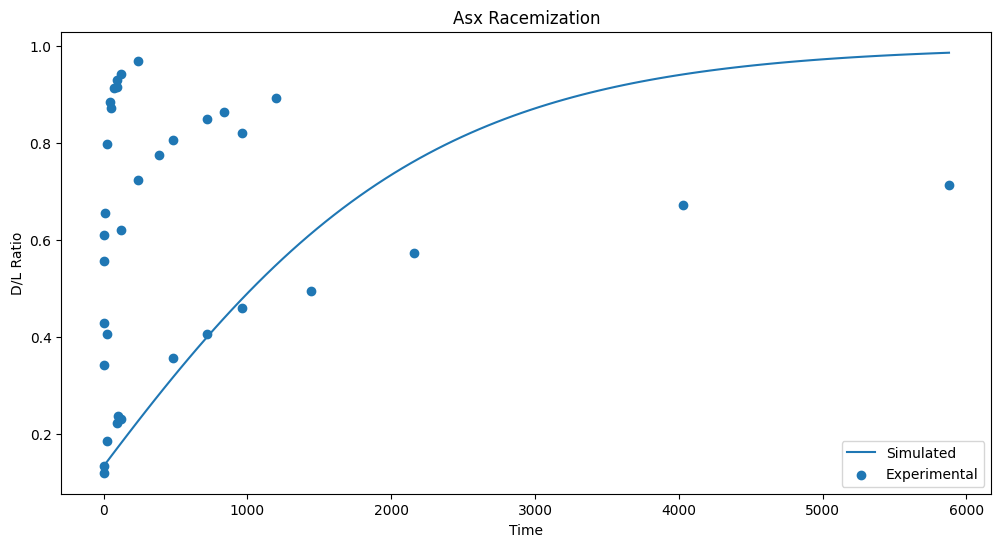

In [44]:
import pandas as pd
import numpy as np

class ModulAAR:
    def __init__(self, config):
        self.config = config
        self.data = None
        self.processed_data = None
        self.logger = self._setup_logger()

    def _setup_logger(self):
        from datetime import datetime
        return lambda msg, level="INFO": print(f"{datetime.now()} - {level} - {msg}")

    def load_data(self, source, is_gsheet=False):
        """Load data from a CSV file or Google Sheets."""
        try:
            if is_gsheet:
                sheet_id = source['sheet_id']
                gid = source['gid']
                export_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"
                self.data = pd.read_csv(export_url)
                self.logger(f"Data loaded successfully from Google Sheet")
            else:
                self.data = pd.read_csv(source)
                self.logger(f"Data loaded successfully from {source}")
        except Exception as e:
            self.logger(f"Error loading data: {str(e)}", "ERROR")
            self.data = None
        return self.data

    def process_data(self, df=None):
        """Process the loaded data based on its type."""
        if df is None:
            df = self.data
        if df is None:
            self.logger("No data available for processing.", "ERROR")
            return None

        df = df.dropna()

        # Flexible column renaming
        rename_mapping = {
            'time (h)': 'time',
            'temp': 'temp (°C)',
            'Pre-heat bleach time': 'Pre-heat bleach time (h)'
            # Add other potential column mappings here if needed
        }
        df.rename(columns=rename_mapping, inplace=True)

        expected_eggshell_columns = [
            'Pre-heat bleach time (h)', 'temp (°C)', 'pH', 'sample', 'time',
            '[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]',
            'Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L'
        ]
        expected_betalactoglobulin_columns = ['Condition', 'Fraction', 'm']

        if all(col in df.columns for col in expected_eggshell_columns):
            self.logger("Processing eggshell data")
            return self._process_eggshell_data(df)
        elif all(col in df.columns for col in expected_betalactoglobulin_columns):
            self.logger("Processing beta-lactoglobulin data")
            return self._process_betalactoglobulin_data(df)
        else:
            self.logger(
                f"Unknown data format. Expected columns for eggshell: {expected_eggshell_columns}, "
                f"or beta-lactoglobulin: {expected_betalactoglobulin_columns}. Found columns: {list(df.columns)}",
                "ERROR"
            )
            return None

    def _process_eggshell_data(self, df):
        """Process eggshell data."""
        df = self.clean_data(df)
        grouped_faa, grouped_thaa = self.calculate_stats(df)

        processed_df = pd.merge(grouped_faa, grouped_thaa, on=['temp (°C)', 'time'], how='outer')

        # Add 'temp (K)' column
        if 'temp (°C)' in processed_df.columns:
            processed_df['temp (K)'] = processed_df['temp (°C)'] + 273.15

        self.logger("Eggshell data processed successfully")
        return processed_df

    def _process_betalactoglobulin_data(self, df):
        """Process beta-lactoglobulin data."""
        relevant_columns = ['Condition', 'Fraction', 'm', '[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]',
                            'Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L']
        df = df[relevant_columns]

        # Convert concentration and D/L columns to numeric
        for col in df.columns:
            if col.startswith('[') or col.endswith('D/L'):
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # Group by condition and calculate statistics
        grouped = df.groupby(['Condition', 'Fraction', 'm']).agg({
            col: ['mean', 'std'] for col in df.columns if col not in ['Condition', 'Fraction', 'm']
        }).reset_index()

        # Flatten column names
        grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

        self.logger("Beta-lactoglobulin data processed successfully")
        return grouped

    def clean_data(self, df):
        """Clean the eggshell data by converting to numeric and filtering."""
        concentration_columns = ['[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]']
        dl_columns = ['Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L']

        for col in concentration_columns + dl_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        df = df.dropna(subset=concentration_columns + dl_columns)
        return df

    def calculate_stats(self, df):
        """Calculate statistics for FAA and THAA samples."""
        faa_df = df[df['sample'] == 'FAA']
        thaa_df = df[df['sample'] == 'THAA']

        grouped_faa = faa_df.groupby(['temp (°C)', 'time']).agg({
            '[Asx]': ['mean', 'std', 'count'],
            '[Glx]': ['mean', 'std', 'count'],
            '[Ser]': ['mean', 'std', 'count'],
            '[Ala]': ['mean', 'std', 'count'],
            '[Val]': ['mean', 'std', 'count'],
            '[Phe]': ['mean', 'std', 'count'],
            '[Ile]': ['mean', 'std', 'count'],
            'Asx D/L': ['mean', 'std', 'count'],
            'Glx D/L': ['mean', 'std', 'count'],
            'Ser D/L': ['mean', 'std', 'count'],
            'Ala D/L': ['mean', 'std', 'count'],
            'Val D/L': ['mean', 'std', 'count'],
            'Phe D/L': ['mean', 'std', 'count'],
            'Ile D/L': ['mean', 'std', 'count']
        }).reset_index()

        grouped_thaa = thaa_df.groupby(['temp (°C)', 'time']).agg({
            '[Asx]': ['mean', 'std', 'count'],
            '[Glx]': ['mean', 'std', 'count'],
            '[Ser]': ['mean', 'std', 'count'],
            '[Ala]': ['mean', 'std', 'count'],
            '[Val]': ['mean', 'std', 'count'],
            '[Phe]': ['mean', 'std', 'count'],
            '[Ile]': ['mean', 'std', 'count'],
            'Asx D/L': ['mean', 'std', 'count'],
            'Glx D/L': ['mean', 'std', 'count'],
            'Ser D/L': ['mean', 'std', 'count'],
            'Ala D/L': ['mean', 'std', 'count'],
            'Val D/L': ['mean', 'std', 'count'],
            'Phe D/L': ['mean', 'std', 'count'],
            'Ile D/L': ['mean', 'std', 'count']
        }).reset_index()

        new_columns_faa = ['temp (°C)', 'time'] + [
            f'{aa}_Conc_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + [
            f'{aa}_D/L_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]
        new_columns_thaa = ['temp (°C)', 'time'] + [
            f'{aa}_Conc_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + [
            f'{aa}_D/L_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]

        grouped_faa.columns = new_columns_faa
        grouped_thaa.columns = new_columns_thaa

        for col in new_columns_faa:
            if '_Std' in col:
                count_col = col.replace('_Std', '_Count')
                grouped_faa.loc[grouped_faa[count_col] == 1, col] = 0

        for col in new_columns_thaa:
            if '_Std' in col:
                count_col = col.replace('_Std', '_Count')
                grouped_thaa.loc[grouped_thaa[count_col] == 1, col] = 0

        return grouped_faa, grouped_thaa

    def calculate_amino_acid_distribution(self, df, amino_acid):
        """Calculate the distribution of a given amino acid."""
        if df is None:
            self.logger("No processed data available. Please process data first.", "ERROR")
            return None

        amino_acid_distributions = []

        initial_thaa = df[f"{amino_acid}_Conc_THAA_Mean"].iloc[0]

        for index, row in df.iterrows():
            thaa = row[f"{amino_acid}_Conc_THAA_Mean"]
            faa = row[f"{amino_acid}_Conc_FAA_Mean"]
            thaa_dl = row[f"{amino_acid}_D/L_THAA_Mean"]
            faa_dl = row[f"{amino_acid}_D/L_FAA_Mean"]
            time_point = row["time"]

            # Calculate BAA, FAA, and losses
            baa = thaa - faa
            baa_d = baa * thaa_dl / (1 + thaa_dl)
            baa_l = baa - baa_d
            faa_d = faa * faa_dl / (1 + faa_dl)
            faa_l = faa - faa_d
            total_loss = max(initial_thaa - thaa, 0)
            loss_d = total_loss * faa_dl / (1 + faa_dl) if total_loss > 0 else 0
            loss_l = total_loss - loss_d if total_loss > 0 else 0

            # Calculate standard deviations
            thaa_std = row[f"{amino_acid}_Conc_THAA_Std"]
            faa_std = row[f"{amino_acid}_Conc_FAA_Std"]
            baa_std = np.sqrt(thaa_std**2 + faa_std**2)
            baa_d_std = baa_std * thaa_dl / (1 + thaa_dl)
            baa_l_std = baa_std - baa_d_std
            faa_d_std = faa_std * faa_dl / (1 + faa_dl)
            faa_l_std = faa_std - faa_d_std
            loss_std = np.sqrt(2 * thaa_std**2)
            loss_d_std = loss_std * faa_dl / (1 + faa_dl)
            loss_l_std = loss_std - loss_d_std

            amino_acid_distributions.append({
                "time": time_point,
                "temp (K)": row["temp (K)"],
                "BAA_D": baa_d, "BAA_L": baa_l,
                "BAA_D_Std": baa_d_std, "BAA_L_Std": baa_l_std,
                "FAA_D": faa_d, "FAA_L": faa_l,
                "FAA_D_Std": faa_d_std, "FAA_L_Std": faa_l_std,
                "FAA_D_loss": loss_d, "FAA_L_loss": loss_l,
                "FAA_D_loss_Std": loss_d_std, "FAA_L_loss_Std": loss_l_std,
            })

        return pd.DataFrame(amino_acid_distributions)

    def simulate(self, amino_acid, time_points):
        """Simulate the racemization process for a given amino acid."""
        if self.processed_data is None:
            self.logger("No processed data available. Please process data first.", "ERROR")
            return None

        initial_conditions = self._get_initial_conditions(amino_acid)
        params = self._get_rate_parameters(amino_acid)

        solution = odeint(self._ode_system, initial_conditions, time_points, args=(params,))

        results = pd.DataFrame({
            'time': time_points,
            'L_int': solution[:, 0],
            'D_int': solution[:, 1],
            'L_term': solution[:, 2],
            'D_term': solution[:, 3],
            'L_free': solution[:, 4],
            'D_free': solution[:, 5],
            'water': solution[:, 6]
        })

        results['DL_ratio'] = (results['D_int'] + results['D_term'] + results['D_free']) / \
                              (results['L_int'] + results['L_term'] + results['L_free'])

        return results

    def _ode_system(self, y, t, params):
        """Define the system of ODEs for the racemization process."""
        L_int, D_int, L_term, D_term, L_free, D_free, water = y
        k_hydrolysis, k_racemization_int, k_racemization_term, k_racemization_free, k_loss, k_water_generation = params

        dL_int = -k_hydrolysis * L_int * water - k_racemization_int * L_int + k_racemization_int * D_int
        dD_int = -k_hydrolysis * D_int * water + k_racemization_int * L_int - k_racemization_int * D_int
        dL_term = k_hydrolysis * L_int * water - k_hydrolysis * L_term * water - k_racemization_term * L_term + k_racemization_term * D_term
        dD_term = k_hydrolysis * D_int * water - k_hydrolysis * D_term * water + k_racemization_term * L_term - k_racemization_term * D_term
        dL_free = k_hydrolysis * L_term * water - k_loss * L_free - k_racemization_free * L_free + k_racemization_free * D_free
        dD_free = k_hydrolysis * D_term * water - k_loss * D_free + k_racemization_free * L_free - k_racemization_free * D_free
        dwater = -k_hydrolysis * (L_int + D_int) * water - k_hydrolysis * (L_term + D_term) * water + k_water_generation

        return [dL_int, dD_int, dL_term, dD_term, dL_free, dD_free, dwater]

    def _get_initial_conditions(self, amino_acid):
        """Get initial conditions for the simulation from processed data."""
        initial_data = self.processed_data.iloc[0]
        total_aa = initial_data[f'{amino_acid}_Conc_THAA_Mean']
        initial_dl_ratio = initial_data[f'{amino_acid}_D/L_THAA_Mean']

        L_initial = total_aa / (1 + initial_dl_ratio)
        D_initial = total_aa - L_initial

        return [
            L_initial * 0.9,  # L_int (assuming 90% is internal)
            D_initial * 0.9,  # D_int
            L_initial * 0.09,  # L_term (assuming 9% is terminal)
            D_initial * 0.09,  # D_term
            L_initial * 0.01,  # L_free (assuming 1% is free)
            D_initial * 0.01,  # D_free
            self.config['N'] * self.config['fold_water']  # initial water
        ]

    def _get_rate_parameters(self, amino_acid):
        """Get rate parameters for the simulation."""
        # These values should be optimized based on experimental data
        return [
            self.config['rate_params'].get('k_hydrolysis', 1e-5),
            self.config['rate_params'].get('k_racemization_int', 1e-6),
            self.config['rate_params'].get('k_racemization_term', 1e-5),
            self.config['rate_params'].get('k_racemization_free', 1e-4),
            self.config['rate_params'].get('k_loss', 1e-7),
            self.config['rate_params'].get('k_water_generation', 1e-8)
        ]

    def optimize_parameters(self, amino_acid, time_points):
        """Optimize rate parameters to fit experimental data."""
        from scipy.optimize import minimize

        def objective(params):
            self.config['rate_params'] = {
                'k_hydrolysis': params[0],
                'k_racemization_int': params[1],
                'k_racemization_term': params[2],
                'k_racemization_free': params[3],
                'k_loss': params[4],
                'k_water_generation': params[5]
            }
            simulated = self.simulate(amino_acid, time_points)
            experimental = self.processed_data[self.processed_data['time'].isin(time_points)]
            error = np.sum((simulated['DL_ratio'] - experimental[f'{amino_acid}_D/L_THAA_Mean'])**2)
            return error

        initial_guess = [1e-5, 1e-6, 1e-5, 1e-4, 1e-7, 1e-8]
        bounds = [(0, 1e-2)] * 6  # Adjust bounds as needed

        result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)

        if result.success:
            self.config['rate_params'] = {
                'k_hydrolysis': result.x[0],
                'k_racemization_int': result.x[1],
                'k_racemization_term': result.x[2],
                'k_racemization_free': result.x[3],
                'k_loss': result.x[4],
                'k_water_generation': result.x[5]
            }
            self.logger(f"Optimized parameters: {self.config['rate_params']}")
        else:
            self.logger("Parameter optimization failed", "ERROR")

    def plot_results(self, amino_acid, simulated_results):
        """Plot simulated results against experimental data."""
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 6))
        plt.plot(simulated_results['time'], simulated_results['DL_ratio'], label='Simulated')
        plt.scatter(self.processed_data['time'], self.processed_data[f'{amino_acid}_D/L_THAA_Mean'], label='Experimental')
        plt.xlabel('Time')
        plt.ylabel('D/L Ratio')
        plt.title(f'{amino_acid} Racemization')
        plt.legend()
        plt.show()

# Usage
config = {
    'N': 50000,
    'fold_water': 8,
    'temperature_kelvin': 353.15,
    'amino_acid': 'Asx',
    'initial_length': 1500,
    'rate_params': {
        'k_hydrolysis': 1e-5,
        'k_racemization_int': 1e-6,
        'k_racemization_term': 1e-5,
        'k_racemization_free': 1e-4,
        'k_loss': 1e-7,
        'k_water_generation': 1e-8
    }
}


model = ModulAAR(config)

# Load and process data
sheet_info = {'sheet_id': "1nA6jSAkAf1Ud-kHdaYTMtBPgKhe9nBg_IjM9idLlj8E", 'gid': "1259514505"}
df1 = model.load_data(sheet_info, is_gsheet=True)
if df1 is not None:
    # Assign the processed DataFrame to the object's attribute
    model.processed_data = model.process_data(df1)  # Change here
    if model.processed_data is not None:
        # Optimize parameters
        time_points = np.linspace(0, model.processed_data['time'].max(), 100)  # Update to use model.processed_data
        model.optimize_parameters('Asx', time_points)

        # Run simulation with optimized parameters
        simulated_results = model.simulate('Asx', time_points)

        # Plot results
        model.plot_results('Asx', simulated_results)



2024-07-05 20:09:50.759644 - INFO - Data loaded successfully from Google Sheet
2024-07-05 20:09:50.764279 - INFO - Processing eggshell data
2024-07-05 20:09:50.865362 - INFO - Eggshell data processed successfully
2024-07-05 20:09:50.948316 - WARNING - No data found for temperature 140°C at the initial time point.


<ipython-input-55-86bc4387f360>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=rename_mapping, inplace=True)
<ipython-input-55-86bc4387f360>:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')


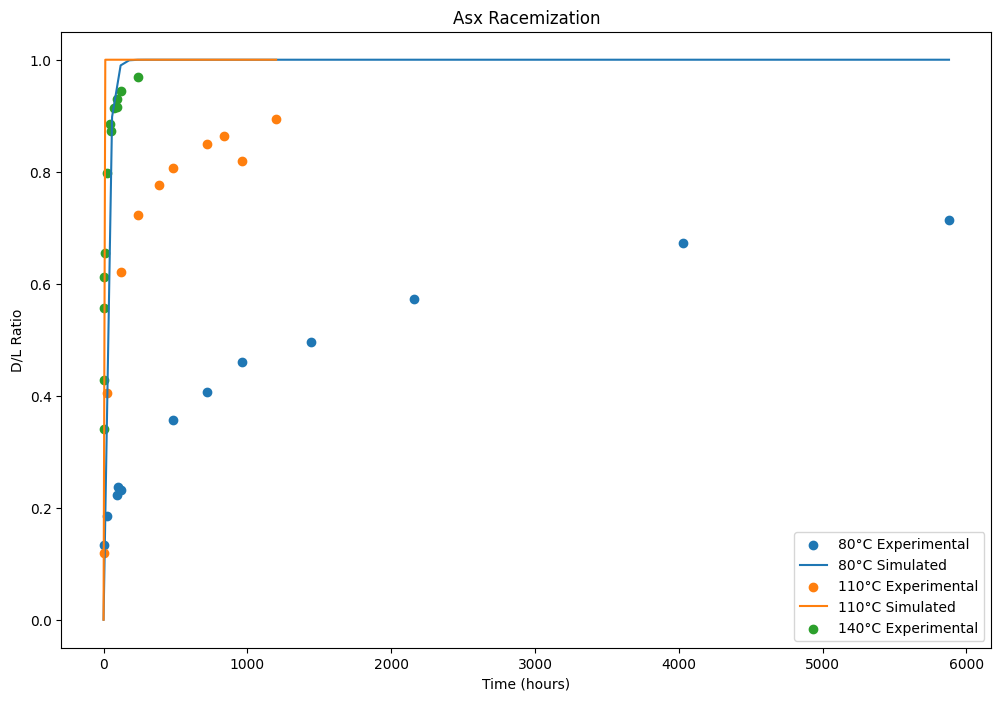

2024-07-05 20:09:51.509721 - WARNING - No data found for temperature 140°C at the initial time point.


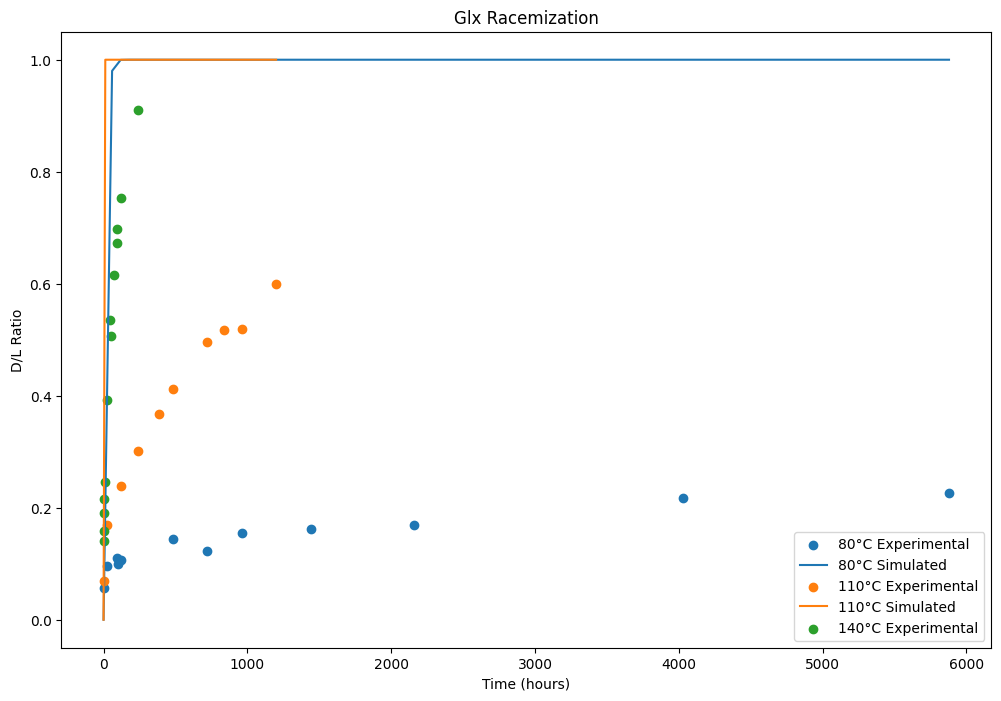

2024-07-05 20:09:52.120900 - WARNING - No data found for temperature 140°C at the initial time point.


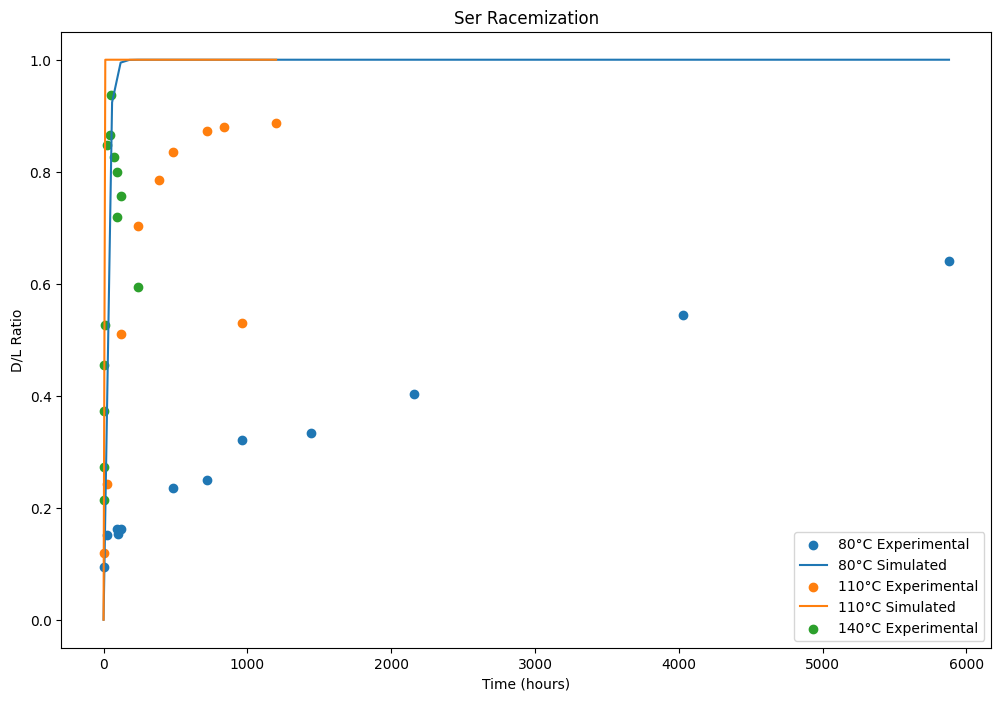

2024-07-05 20:09:52.573563 - WARNING - No data found for temperature 140°C at the initial time point.


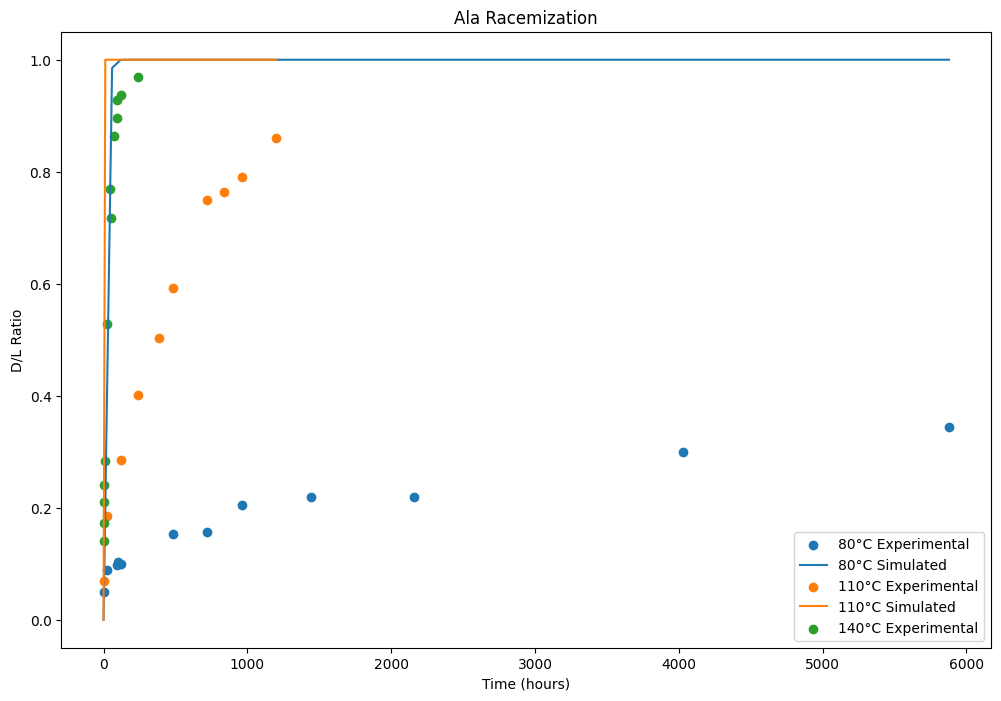

2024-07-05 20:09:52.978066 - WARNING - No data found for temperature 140°C at the initial time point.


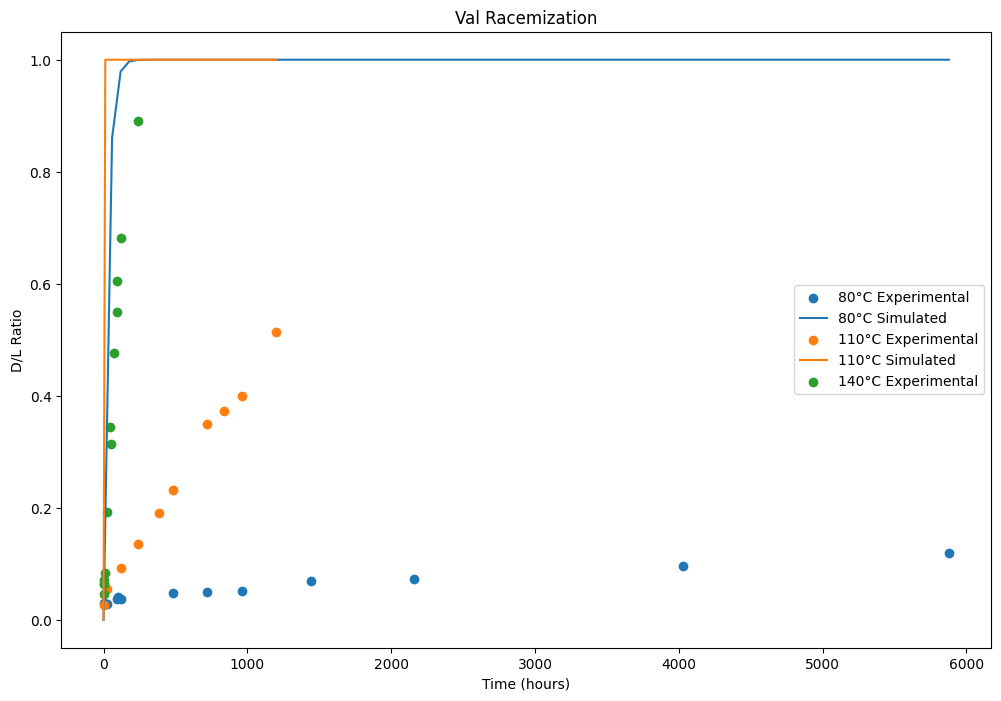

2024-07-05 20:09:53.362798 - WARNING - No data found for temperature 140°C at the initial time point.


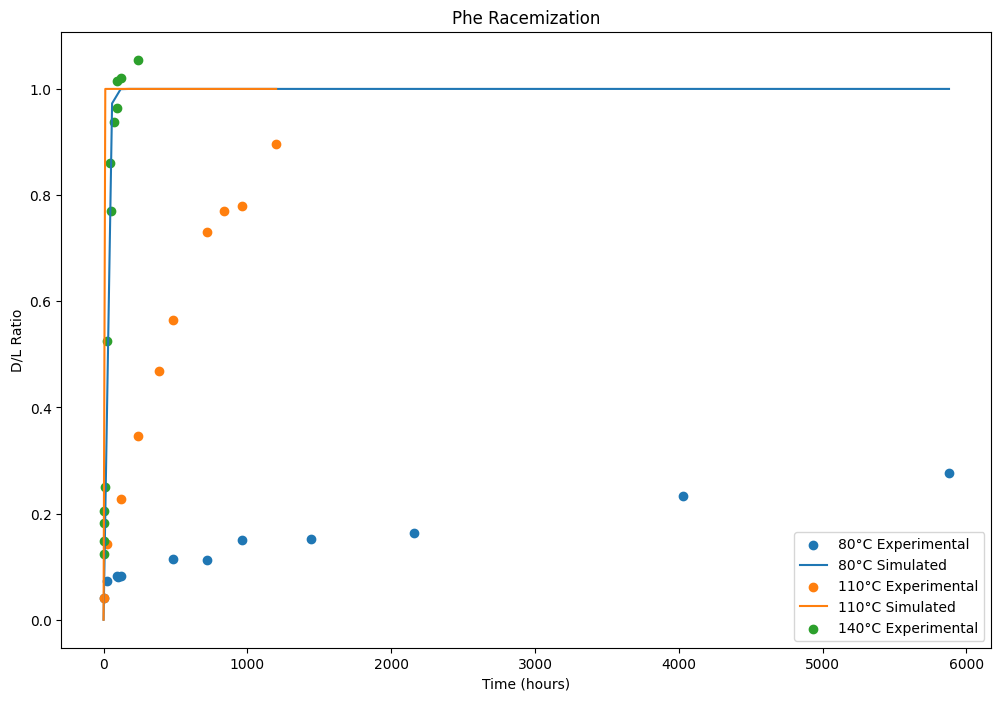

2024-07-05 20:09:53.764281 - WARNING - No data found for temperature 140°C at the initial time point.


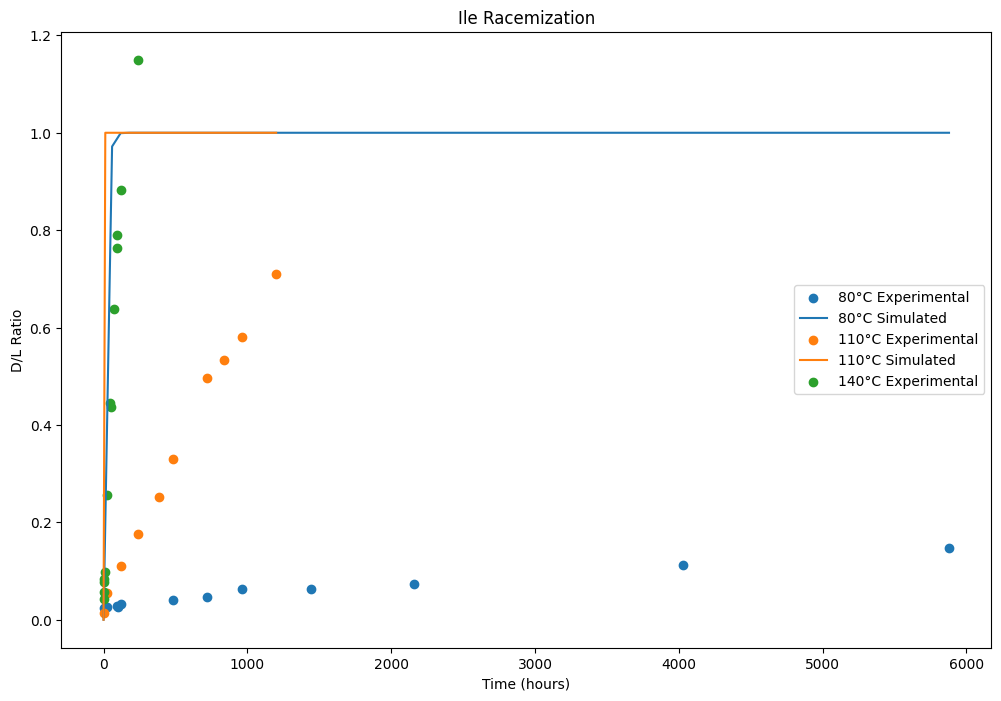

In [55]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class ModulAAR:
    def __init__(self, config):
        self.config = config
        self.data = None
        self.processed_data = None
        self.logger = self._setup_logger()
        self.temperatures = []
        self.amino_acids = []
        self.activation_energies = {
            'Hydrolysis': 114 * 1000, 'Dehydration': 114 * 1000,
            'Asx_ConcBAA': 111.09 * 1000, 'Asx_ConcFAA': 98.93 * 1000, 'Asx_DL_BAA': 126.02 * 1000, 'Asx_DL_FAA': 121.99 * 1000,
            'Glx_ConcBAA': 105.46 * 1000, 'Glx_ConcFAA': 109.39 * 1000, 'Glx_DL_BAA': 121.89 * 1000, 'Glx_DL_FAA': 100.80 * 1000,
            'Ser_ConcBAA': 127.59 * 1000, 'Ser_ConcFAA': 97.95 * 1000, 'Ser_DL_BAA': 123.03 * 1000, 'Ser_DL_FAA': 116.72 * 1000,
            'Ala_ConcBAA': 96.58 * 1000, 'Ala_ConcFAA': 112.12 * 1000, 'Ala_DL_BAA': 113.58 * 1000, 'Ala_DL_FAA': 98.88 * 1000,
            'Val_ConcBAA': 111.00 * 1000, 'Val_ConcFAA': 122.81 * 1000, 'Val_DL_BAA': 99.73 * 1000, 'Val_DL_FAA': 128.52 * 1000,
            'Phe_ConcBAA': 113.28 * 1000, 'Phe_ConcFAA': 98.88 * 1000, 'Phe_DL_BAA': 128.15 * 1000, 'Phe_DL_FAA': 102.27 * 1000,
            'Leu_ConcBAA': 114.09 * 1000, 'Leu_ConcFAA': 103.75 * 1000, 'Leu_DL_BAA': 105.43 * 1000, 'Leu_DL_FAA': 105.43 * 1000,
            'Ile_ConcBAA': 114.09 * 1000, 'Ile_ConcFAA': 103.75 * 1000, 'Ile_DL_BAA': 105.43 * 1000, 'Ile_DL_FAA': 105.43 * 1000
        }
        self.R = 8.314  # Gas constant in J/(mol·K)
        self.rate_constants = {}
        self.water_generation = {}

    def _setup_logger(self):
          return lambda msg, level="INFO": print(f"{datetime.now()} - {level} - {msg}")

    def load_data(self, source, is_gsheet=False):
          """Load data from a CSV file or Google Sheets."""
          try:
              if is_gsheet:
                  sheet_id = source['sheet_id']
                  gid = source['gid']
                  export_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"
                  self.data = pd.read_csv(export_url)
                  self.logger(f"Data loaded successfully from Google Sheet")
              else:
                  self.data = pd.read_csv(source)
                  self.logger(f"Data loaded successfully from {source}")
          except Exception as e:
              self.logger(f"Error loading data: {str(e)}", "ERROR")
              self.data = None
          return self.data

    def process_data(self, df=None):
        """Process the loaded data based on its type."""
        if df is None:
            df = self.data
        if df is None:
            self.logger("No data available for processing.", "ERROR")
            return None

        df = df.dropna()

        # Flexible column renaming
        rename_mapping = {
            'time (h)': 'time',
            'temp': 'temp (°C)',
            'Pre-heat bleach time': 'Pre-heat bleach time (h)'
            # Add other potential column mappings here if needed
        }
        df.rename(columns=rename_mapping, inplace=True)

        expected_eggshell_columns = [
            'Pre-heat bleach time (h)', 'temp (°C)', 'pH', 'sample', 'time',
            '[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]',
            'Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L'
        ]
        expected_betalactoglobulin_columns = ['Condition', 'Fraction', 'm']

        if all(col in df.columns for col in expected_eggshell_columns):
            self.logger("Processing eggshell data")
            return self._process_eggshell_data(df)
        elif all(col in df.columns for col in expected_betalactoglobulin_columns):
            self.logger("Processing beta-lactoglobulin data")
            return self._process_betalactoglobulin_data(df)
        else:
            self.logger(
                f"Unknown data format. Expected columns for eggshell: {expected_eggshell_columns}, "
                f"or beta-lactoglobulin: {expected_betalactoglobulin_columns}. Found columns: {list(df.columns)}",
                "ERROR"
            )
            return None

    def _process_eggshell_data(self, df):
        """Process eggshell data."""
        df = self.clean_data(df)
        grouped_faa, grouped_thaa = self.calculate_stats(df)

        processed_df = pd.merge(grouped_faa, grouped_thaa, on=['temp (°C)', 'time'], how='outer')

        # Add 'temp (K)' column
        if 'temp (°C)' in processed_df.columns:
            processed_df['temp (K)'] = processed_df['temp (°C)'] + 273.15

        self.logger("Eggshell data processed successfully")
        return processed_df

    def _process_betalactoglobulin_data(self, df):
        """Process beta-lactoglobulin data."""
        relevant_columns = ['Condition', 'Fraction', 'm', '[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]',
                            'Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L']
        df = df[relevant_columns]

        # Convert concentration and D/L columns to numeric
        for col in df.columns:
            if col.startswith('[') or col.endswith('D/L'):
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # Group by condition and calculate statistics
        grouped = df.groupby(['Condition', 'Fraction', 'm']).agg({
            col: ['mean', 'std'] for col in df.columns if col not in ['Condition', 'Fraction', 'm']
        }).reset_index()

        # Flatten column names
        grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

        self.logger("Beta-lactoglobulin data processed successfully")
        return grouped

    def clean_data(self, df):
        """Clean the eggshell data by converting to numeric and filtering."""
        concentration_columns = ['[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]']
        dl_columns = ['Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L']

        for col in concentration_columns + dl_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        df = df.dropna(subset=concentration_columns + dl_columns)
        return df

    def calculate_stats(self, df):
        """Calculate statistics for FAA and THAA samples."""
        faa_df = df[df['sample'] == 'FAA']
        thaa_df = df[df['sample'] == 'THAA']

        grouped_faa = faa_df.groupby(['temp (°C)', 'time']).agg({
            '[Asx]': ['mean', 'std', 'count'],
            '[Glx]': ['mean', 'std', 'count'],
            '[Ser]': ['mean', 'std', 'count'],
            '[Ala]': ['mean', 'std', 'count'],
            '[Val]': ['mean', 'std', 'count'],
            '[Phe]': ['mean', 'std', 'count'],
            '[Ile]': ['mean', 'std', 'count'],
            'Asx D/L': ['mean', 'std', 'count'],
            'Glx D/L': ['mean', 'std', 'count'],
            'Ser D/L': ['mean', 'std', 'count'],
            'Ala D/L': ['mean', 'std', 'count'],
            'Val D/L': ['mean', 'std', 'count'],
            'Phe D/L': ['mean', 'std', 'count'],
            'Ile D/L': ['mean', 'std', 'count']
        }).reset_index()

        grouped_thaa = thaa_df.groupby(['temp (°C)', 'time']).agg({
            '[Asx]': ['mean', 'std', 'count'],
            '[Glx]': ['mean', 'std', 'count'],
            '[Ser]': ['mean', 'std', 'count'],
            '[Ala]': ['mean', 'std', 'count'],
            '[Val]': ['mean', 'std', 'count'],
            '[Phe]': ['mean', 'std', 'count'],
            '[Ile]': ['mean', 'std', 'count'],
            'Asx D/L': ['mean', 'std', 'count'],
            'Glx D/L': ['mean', 'std', 'count'],
            'Ser D/L': ['mean', 'std', 'count'],
            'Ala D/L': ['mean', 'std', 'count'],
            'Val D/L': ['mean', 'std', 'count'],
            'Phe D/L': ['mean', 'std', 'count'],
            'Ile D/L': ['mean', 'std', 'count']
        }).reset_index()

        new_columns_faa = ['temp (°C)', 'time'] + [
            f'{aa}_Conc_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + [
            f'{aa}_D/L_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]
        new_columns_thaa = ['temp (°C)', 'time'] + [
            f'{aa}_Conc_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + [
            f'{aa}_D/L_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]

        grouped_faa.columns = new_columns_faa
        grouped_thaa.columns = new_columns_thaa

        for col in new_columns_faa:
            if '_Std' in col:
                count_col = col.replace('_Std', '_Count')
                grouped_faa.loc[grouped_faa[count_col] == 1, col] = 0

        for col in new_columns_thaa:
            if '_Std' in col:
                count_col = col.replace('_Std', '_Count')
                grouped_thaa.loc[grouped_thaa[count_col] == 1, col] = 0

        return grouped_faa, grouped_thaa

    def calculate_amino_acid_distribution(self, df, amino_acid):
        """Calculate the distribution of a given amino acid."""
        if df is None:
            self.logger("No processed data available. Please process data first.", "ERROR")
            return None

        amino_acid_distributions = []

        initial_thaa = df[f"{amino_acid}_Conc_THAA_Mean"].iloc[0]

        for index, row in df.iterrows():
            thaa = row[f"{amino_acid}_Conc_THAA_Mean"]
            faa = row[f"{amino_acid}_Conc_FAA_Mean"]
            thaa_dl = row[f"{amino_acid}_D/L_THAA_Mean"]
            faa_dl = row[f"{amino_acid}_D/L_FAA_Mean"]
            time_point = row["time"]

            # Calculate BAA, FAA, and losses
            baa = thaa - faa
            baa_d = baa * thaa_dl / (1 + thaa_dl)
            baa_l = baa - baa_d
            faa_d = faa * faa_dl / (1 + faa_dl)
            faa_l = faa - faa_d
            total_loss = max(initial_thaa - thaa, 0)
            loss_d = total_loss * faa_dl / (1 + faa_dl) if total_loss > 0 else 0
            loss_l = total_loss - loss_d if total_loss > 0 else 0

            # Calculate standard deviations
            thaa_std = row[f"{amino_acid}_Conc_THAA_Std"]
            faa_std = row[f"{amino_acid}_Conc_FAA_Std"]
            baa_std = np.sqrt(thaa_std**2 + faa_std**2)
            baa_d_std = baa_std * thaa_dl / (1 + thaa_dl)
            baa_l_std = baa_std - baa_d_std
            faa_d_std = faa_std * faa_dl / (1 + faa_dl)
            faa_l_std = faa_std - faa_d_std
            loss_std = np.sqrt(2 * thaa_std**2)
            loss_d_std = loss_std * faa_dl / (1 + faa_dl)
            loss_l_std = loss_std - loss_d_std

            amino_acid_distributions.append({
                "time": time_point,
                "temp (K)": row["temp (K)"],
                "BAA_D": baa_d, "BAA_L": baa_l,
                "BAA_D_Std": baa_d_std, "BAA_L_Std": baa_l_std,
                "FAA_D": faa_d, "FAA_L": faa_l,
                "FAA_D_Std": faa_d_std, "FAA_L_Std": faa_l_std,
                "FAA_D_loss": loss_d, "FAA_L_loss": loss_l,
                "FAA_D_loss_Std": loss_d_std, "FAA_L_loss_Std": loss_l_std,
            })

        return pd.DataFrame(amino_acid_distributions)

    def simulate(self, amino_acid, time_points):
        """Simulate the racemization process for a given amino acid."""
        if self.processed_data is None:
            self.logger("No processed data available. Please process data first.", "ERROR")
            return None

        initial_conditions = self._get_initial_conditions(amino_acid)
        params = self._get_rate_parameters(amino_acid)

        solution = odeint(self._ode_system, initial_conditions, time_points, args=(params,))

        results = pd.DataFrame({
            'time': time_points,
            'L_int': solution[:, 0],
            'D_int': solution[:, 1],
            'L_term': solution[:, 2],
            'D_term': solution[:, 3],
            'L_free': solution[:, 4],
            'D_free': solution[:, 5],
            'water': solution[:, 6]
        })

        results['DL_ratio'] = (results['D_int'] + results['D_term'] + results['D_free']) / \
                              (results['L_int'] + results['L_term'] + results['L_free'])

        return results

    def _ode_system(self, y, t, params):
        """Define the system of ODEs for the racemization process."""
        L_int, D_int, L_term, D_term, L_free, D_free, water = y
        k_hydrolysis, k_racemization_int, k_racemization_term, k_racemization_free, k_loss, k_water_generation = params

        dL_int = -k_hydrolysis * L_int * water - k_racemization_int * L_int + k_racemization_int * D_int
        dD_int = -k_hydrolysis * D_int * water + k_racemization_int * L_int - k_racemization_int * D_int
        dL_term = k_hydrolysis * L_int * water - k_hydrolysis * L_term * water - k_racemization_term * L_term + k_racemization_term * D_term
        dD_term = k_hydrolysis * D_int * water - k_hydrolysis * D_term * water + k_racemization_term * L_term - k_racemization_term * D_term
        dL_free = k_hydrolysis * L_term * water - k_loss * L_free - k_racemization_free * L_free + k_racemization_free * D_free
        dD_free = k_hydrolysis * D_term * water - k_loss * D_free + k_racemization_free * L_free - k_racemization_free * D_free
        dwater = -k_hydrolysis * (L_int + D_int) * water - k_hydrolysis * (L_term + D_term) * water + k_water_generation

        return [dL_int, dD_int, dL_term, dD_term, dL_free, dD_free, dwater]

    def _get_initial_conditions(self, amino_acid):
        """Get initial conditions for the simulation from processed data."""
        initial_data = self.processed_data.iloc[0]
        total_aa = initial_data[f'{amino_acid}_Conc_THAA_Mean']
        initial_dl_ratio = initial_data[f'{amino_acid}_D/L_THAA_Mean']

        L_initial = total_aa / (1 + initial_dl_ratio)
        D_initial = total_aa - L_initial

        return [
            L_initial * 0.9,  # L_int (assuming 90% is internal)
            D_initial * 0.9,  # D_int
            L_initial * 0.09,  # L_term (assuming 9% is terminal)
            D_initial * 0.09,  # D_term
            L_initial * 0.01,  # L_free (assuming 1% is free)
            D_initial * 0.01,  # D_free
            self.config['N'] * self.config['fold_water']  # initial water
        ]

    def _get_rate_parameters(self, amino_acid):
        """Get rate parameters for the simulation."""
        # These values should be optimized based on experimental data
        return [
            self.config['rate_params'].get('k_hydrolysis', 1e-5),
            self.config['rate_params'].get('k_racemization_int', 1e-6),
            self.config['rate_params'].get('k_racemization_term', 1e-5),
            self.config['rate_params'].get('k_racemization_free', 1e-4),
            self.config['rate_params'].get('k_loss', 1e-7),
            self.config['rate_params'].get('k_water_generation', 1e-8)
        ]

    def optimize_parameters(self, amino_acid, time_points):
        """Optimize rate parameters to fit experimental data."""
        from scipy.optimize import minimize

        def objective(params):
            self.config['rate_params'] = {
                'k_hydrolysis': params[0],
                'k_racemization_int': params[1],
                'k_racemization_term': params[2],
                'k_racemization_free': params[3],
                'k_loss': params[4],
                'k_water_generation': params[5]
            }
            simulated = self.simulate(amino_acid, time_points)
            experimental = self.processed_data[self.processed_data['time'].isin(time_points)]
            error = np.sum((simulated['DL_ratio'] - experimental[f'{amino_acid}_D/L_THAA_Mean'])**2)
            return error

        initial_guess = [1e-5, 1e-6, 1e-5, 1e-4, 1e-7, 1e-8]
        bounds = [(0, 1e-2)] * 6  # Adjust bounds as needed

        result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)

        if result.success:
            self.config['rate_params'] = {
                'k_hydrolysis': result.x[0],
                'k_racemization_int': result.x[1],
                'k_racemization_term': result.x[2],
                'k_racemization_free': result.x[3],
                'k_loss': result.x[4],
                'k_water_generation': result.x[5]
            }
            self.logger(f"Optimized parameters: {self.config['rate_params']}")
        else:
            self.logger("Parameter optimization failed", "ERROR")

    def plot_results(self, amino_acid, simulated_results):
        """Plot simulated results against experimental data."""
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 6))
        plt.plot(simulated_results['time'], simulated_results['DL_ratio'], label='Simulated')
        plt.scatter(self.processed_data['time'], self.processed_data[f'{amino_acid}_D/L_THAA_Mean'], label='Experimental')
        plt.xlabel('Time')
        plt.ylabel('D/L Ratio')
        plt.title(f'{amino_acid} Racemization')
        plt.legend()
        plt.show()

    def _extract_temperatures_and_amino_acids(self):
        if 'temp (°C)' in self.processed_data.columns:
            self.temperatures = sorted(self.processed_data['temp (°C)'].unique())
        elif 'temp (K)' in self.processed_data.columns:
            self.temperatures = sorted(self.processed_data['temp (K)'].unique() - 273.15)
        else:
            self.logger("Temperature column not found in processed data", "ERROR")
            return

        self.amino_acids = []
        for col in self.processed_data.columns:
            if '_Conc_THAA_Mean' in col:
                aa = col.split('_')[0]
                if aa not in self.amino_acids:
                    self.amino_acids.append(aa)

        if not self.amino_acids:
            self.logger("No amino acid concentration columns found in processed data", "ERROR")

    def calculate_rate_constants(self):
        for aa in self.amino_acids:
            for temp in self.temperatures:
                temp_K = temp + 273.15
                for process in ['ConcBAA', 'ConcFAA', 'DL_BAA', 'DL_FAA']:
                    key = f"{aa}_{process}"
                    Ea = self.activation_energies[key]
                    # Assuming a reference temperature of 110°C and a reference rate constant of 1
                    k_ref = 1
                    T_ref = 110 + 273.15
                    k = k_ref * np.exp((Ea / self.R) * (1/T_ref - 1/temp_K))
                    self.rate_constants[f"{key}_{temp}"] = k

    def analyze_amino_acids(self):
        for aa in self.amino_acids:
            for temp in self.temperatures:
                temp_data = self.processed_data[self.processed_data['temp (°C)'] == temp]
                initial_conc_thaa = temp_data[f'{aa}_Conc_THAA_Mean'].iloc[0]
                final_conc_thaa = temp_data[f'{aa}_Conc_THAA_Mean'].iloc[-1]
                initial_conc_faa = temp_data[f'{aa}_Conc_FAA_Mean'].iloc[0]
                final_conc_faa = temp_data[f'{aa}_Conc_FAA_Mean'].iloc[-1]
                time_span = temp_data['time'].max() - temp_data['time'].min()

                thaa_loss_rate = (initial_conc_thaa - final_conc_thaa) / time_span
                faa_change_rate = (final_conc_faa - initial_conc_faa) / time_span

                self.rate_constants[f"{aa}_THAA_loss_{temp}"] = thaa_loss_rate
                self.rate_constants[f"{aa}_FAA_change_{temp}"] = faa_change_rate

    def calculate_water_generation(self):
        for temp in self.temperatures:
            temp_data = self.processed_data[self.processed_data['temp (°C)'] == temp]
            ser_loss = temp_data['Ser_Conc_THAA_Mean'].iloc[0] - temp_data['Ser_Conc_THAA_Mean'].iloc[-1]
            ala_increase = temp_data['Ala_Conc_THAA_Mean'].iloc[-1] - temp_data['Ala_Conc_THAA_Mean'].iloc[0]
            self.water_generation[temp] = ser_loss + ala_increase

    def simulate_racemization(self, aa, temp, time_points):
            k_thaa = self.rate_constants[f"{aa}_DL_BAA_{temp}"]
            k_faa = self.rate_constants[f"{aa}_DL_FAA_{temp}"]
            k_hydrolysis = self.rate_constants[f"{aa}_ConcBAA_{temp}"]

            def model(t, initial_thaa, initial_faa):
                thaa = initial_thaa * np.exp(-k_hydrolysis * t)
                faa = initial_faa + initial_thaa * (1 - np.exp(-k_hydrolysis * t))
                dl_thaa = 1 - np.exp(-k_thaa * t)
                dl_faa = 1 - np.exp(-k_faa * t)
                total_dl = (thaa * dl_thaa + faa * dl_faa) / (thaa + faa)
                return total_dl

            # Filter the DataFrame for the given temperature and minimum time
            filtered_data = self.processed_data[(self.processed_data['temp (°C)'] == temp) & (self.processed_data['time'] == self.processed_data['time'].min())]

            # Check if the filtered DataFrame is empty
            # Handle the case where no data is found
            if filtered_data.empty:
                self.logger(f"No data found for temperature {temp}°C at the initial time point.", "WARNING")
                return None  # Return None to indicate no data


            initial_thaa = filtered_data[f'{aa}_Conc_THAA_Mean'].iloc[0]
            initial_faa = filtered_data[f'{aa}_Conc_FAA_Mean'].iloc[0]

            return model(time_points, initial_thaa, initial_faa)

    # def plot_results(self, aa):
    #     plt.figure(figsize=(12, 8))
    #     for temp in self.temperatures:
    #         temp_data = self.processed_data[self.processed_data['temp (°C)'] == temp]
    #         plt.scatter(temp_data['time'], temp_data[f'{aa}_D/L_THAA_Mean'], label=f'{temp}°C Experimental')

    #         time_points = np.linspace(temp_data['time'].min(), temp_data['time'].max(), 100)
    #         simulated_dl = self.simulate_racemization(aa, temp, time_points)
    #         plt.plot(time_points, simulated_dl, label=f'{temp}°C Simulated')

    #     plt.xlabel('Time (hours)')
    #     plt.ylabel('D/L Ratio')
    #     plt.title(f'{aa} Racemization')
    #     plt.legend()
    #     plt.show()

    def plot_results(self, aa):
        plt.figure(figsize=(12, 8))
        for temp in self.temperatures:
            temp_data = self.processed_data[self.processed_data['temp (°C)'] == temp]
            # Check if temp_data is empty before accessing elements
            if not temp_data.empty:
                plt.scatter(temp_data['time'], temp_data[f'{aa}_D/L_THAA_Mean'], label=f'{temp}°C Experimental')

                time_points = np.linspace(temp_data['time'].min(), temp_data['time'].max(), 100)
                simulated_dl = self.simulate_racemization(aa, temp, time_points)
                # Check if simulated_dl is not None before plotting
                if simulated_dl is not None:
                    plt.plot(time_points, simulated_dl, label=f'{temp}°C Simulated')

        plt.xlabel('Time (hours)')
        plt.ylabel('D/L Ratio')
        plt.title(f'{aa} Racemization')
        plt.legend()
        plt.show()

    def run_analysis(self):
        self._extract_temperatures_and_amino_acids()
        self.calculate_rate_constants()
        self.analyze_amino_acids()
        self.calculate_water_generation()
        for aa in self.amino_acids:
            self.plot_results(aa)

# Usage remains the same
config = {
    'N': 50000,
    'fold_water': 8,
    'temperature_kelvin': 353.15,
    'amino_acid': 'Asx',
    'initial_length': 1500,
    'rate_params': {
        'k_hydrolysis': 1e-5,
        'k_racemization_int': 1e-6,
        'k_racemization_term': 1e-5,
        'k_racemization_free': 1e-4,
        'k_loss': 1e-7,
        'k_water_generation': 1e-8
    }
}

model = ModulAAR(config)

# Load and process data
sheet_info = {'sheet_id': "1nA6jSAkAf1Ud-kHdaYTMtBPgKhe9nBg_IjM9idLlj8E", 'gid': "1259514505"}
df1 = model.load_data(sheet_info, is_gsheet=True)
if df1 is not None:
    model.processed_data = model.process_data(df1)
    if model.processed_data is not None:
        model.run_analysis()

###The Old stuff


---



In [39]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

class EnhancedAminoAcidRacemizationAnalyzer:
    def __init__(self, data):
        self.data = data
        self.temperatures = [80, 110, 140]  # °C
        self.amino_acids = ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Leu', 'Ile']
        self.activation_energies = {
            'Hydrolysis': 114 * 1000, 'Dehydration': 114 * 1000,
            'Asx_ConcBAA': 111.09 * 1000, 'Asx_ConcFAA': 98.93 * 1000, 'Asx_DL_BAA': 126.02 * 1000, 'Asx_DL_FAA': 121.99 * 1000,
            'Glx_ConcBAA': 105.46 * 1000, 'Glx_ConcFAA': 109.39 * 1000, 'Glx_DL_BAA': 121.89 * 1000, 'Glx_DL_FAA': 100.80 * 1000,
            'Ser_ConcBAA': 127.59 * 1000, 'Ser_ConcFAA': 97.95 * 1000, 'Ser_DL_BAA': 123.03 * 1000, 'Ser_DL_FAA': 116.72 * 1000,
            'Ala_ConcBAA': 96.58 * 1000, 'Ala_ConcFAA': 112.12 * 1000, 'Ala_DL_BAA': 113.58 * 1000, 'Ala_DL_FAA': 98.88 * 1000,
            'Val_ConcBAA': 111.00 * 1000, 'Val_ConcFAA': 122.81 * 1000, 'Val_DL_BAA': 99.73 * 1000, 'Val_DL_FAA': 128.52 * 1000,
            'Phe_ConcBAA': 113.28 * 1000, 'Phe_ConcFAA': 98.88 * 1000, 'Phe_DL_BAA': 128.15 * 1000, 'Phe_DL_FAA': 102.27 * 1000,
            'Leu_ConcBAA': 114.09 * 1000, 'Leu_ConcFAA': 103.75 * 1000, 'Leu_DL_BAA': 105.43 * 1000, 'Leu_DL_FAA': 105.43 * 1000,
            'Ile_ConcBAA': 114.09 * 1000, 'Ile_ConcFAA': 103.75 * 1000, 'Ile_DL_BAA': 105.43 * 1000, 'Ile_DL_FAA': 105.43 * 1000
        }
        self.R = 8.314  # Gas constant in J/(mol·K)
        self.rate_constants = {}
        self.water_generation = {}

    def calculate_rate_constants(self):
        for aa in self.amino_acids:
            for temp in self.temperatures:
                temp_K = temp + 273.15
                for process in ['ConcBAA', 'ConcFAA', 'DL_BAA', 'DL_FAA']:
                    key = f"{aa}_{process}"
                    Ea = self.activation_energies[key]
                    # Assuming a reference temperature of 110°C and a reference rate constant of 1
                    k_ref = 1
                    T_ref = 110 + 273.15
                    k = k_ref * np.exp((Ea / self.R) * (1/T_ref - 1/temp_K))
                    self.rate_constants[f"{key}_{temp}"] = k

    def analyze_amino_acids(self):
        for aa in self.amino_acids:
            for temp in self.temperatures:
                temp_data = self.data[self.data['temp (°C)'] == temp]
                initial_conc_baa = temp_data[f'{aa}_Conc_THAA_Mean'].iloc[0] - temp_data[f'{aa}_Conc_FAA_Mean'].iloc[0]
                final_conc_baa = temp_data[f'{aa}_Conc_THAA_Mean'].iloc[-1] - temp_data[f'{aa}_Conc_FAA_Mean'].iloc[-1]
                initial_conc_faa = temp_data[f'{aa}_Conc_FAA_Mean'].iloc[0]
                final_conc_faa = temp_data[f'{aa}_Conc_FAA_Mean'].iloc[-1]
                time_span = temp_data['time'].iloc[-1] - temp_data['time'].iloc[0]

                baa_loss_rate = (initial_conc_baa - final_conc_baa) / time_span
                faa_change_rate = (final_conc_faa - initial_conc_faa) / time_span

                self.rate_constants[f"{aa}_BAA_loss_{temp}"] = baa_loss_rate
                self.rate_constants[f"{aa}_FAA_change_{temp}"] = faa_change_rate

    def calculate_water_generation(self):
        for temp in self.temperatures:
            temp_data = self.data[self.data['temp (°C)'] == temp]
            ser_loss = temp_data['Ser_Conc_THAA_Mean'].iloc[0] - temp_data['Ser_Conc_THAA_Mean'].iloc[-1]
            ala_increase = temp_data['Ala_Conc_THAA_Mean'].iloc[-1] - temp_data['Ala_Conc_THAA_Mean'].iloc[0]
            self.water_generation[temp] = ser_loss + ala_increase

    def simulate_racemization(self, aa, temp, time_points):
        k_baa = self.rate_constants[f"{aa}_DL_BAA_{temp}"]
        k_faa = self.rate_constants[f"{aa}_DL_FAA_{temp}"]
        k_hydrolysis = self.rate_constants[f"{aa}_ConcBAA_{temp}"]

        def model(t, initial_baa, initial_faa):
            baa = initial_baa * np.exp(-k_hydrolysis * t)
            faa = initial_faa + initial_baa * (1 - np.exp(-k_hydrolysis * t))
            dl_baa = 1 - np.exp(-k_baa * t)
            dl_faa = 1 - np.exp(-k_faa * t)
            total_dl = (baa * dl_baa + faa * dl_faa) / (baa + faa)
            return total_dl

        initial_baa = self.data[(self.data['temp (°C)'] == temp) & (self.data['time'] == 0)][f'{aa}_Conc_THAA_Mean'].iloc[0]
        initial_faa = self.data[(self.data['temp (°C)'] == temp) & (self.data['time'] == 0)][f'{aa}_Conc_FAA_Mean'].iloc[0]

        return model(time_points, initial_baa, initial_faa)

    def plot_results(self, aa):
        plt.figure(figsize=(12, 8))
        for temp in self.temperatures:
            temp_data = self.data[self.data['temp (°C)'] == temp]
            plt.scatter(temp_data['time'], temp_data[f'{aa}_D/L_THAA_Mean'], label=f'{temp}°C Experimental')

            time_points = np.linspace(0, temp_data['time'].max(), 100)
            simulated_dl = self.simulate_racemization(aa, temp, time_points)
            plt.plot(time_points, simulated_dl, label=f'{temp}°C Simulated')

        plt.xlabel('Time (hours)')
        plt.ylabel('D/L Ratio')
        plt.title(f'{aa} Racemization')
        plt.legend()
        plt.show()

# Usage
analyzer = EnhancedAminoAcidRacemizationAnalyzer(data)  # Assume 'data' is your DataFrame
analyzer.calculate_rate_constants()
analyzer.analyze_amino_acids()
analyzer.calculate_water_generation()

# Plot results for each amino acid
for aa in analyzer.amino_acids:
    analyzer.plot_results(aa)

NameError: name 'data' is not defined

In [ ]:
#@title Global Variables and Constants
# Precomputed activation energies in kJ/mol (converted to J/mol)
activation_energies = {
    'Asx_ConcTHAA': 111.09 * 1000, 'Asx_ConcFAA': 98.93 * 1000, 'Asx_DLTHAA': 126.02 * 1000, 'Asx_DLFAA': 121.99 * 1000,
    'Glx_ConcTHAA': 105.46 * 1000, 'Glx_ConcFAA': 109.39 * 1000, 'Glx_DLTHAA': 121.89 * 1000, 'Glx_DLFAA': 100.80 * 1000,
    'Ser_ConcTHAA': 127.59 * 1000, 'Ser_ConcFAA': 97.95 * 1000, 'Ser_DLTHAA': 123.03 * 1000, 'Ser_DLFAA': 116.72 * 1000,
    'Ala_ConcTHAA': 96.58 * 1000, 'Ala_ConcFAA': 112.12 * 1000, 'Ala_DLTHAA': 113.58 * 1000, 'Ala_DLFAA': 98.88 * 1000,
    'Val_ConcTHAA': 111.00 * 1000, 'Val_ConcFAA': 122.81 * 1000, 'Val_DLTHAA': 99.73 * 1000, 'Val_DLFAA': 128.52 * 1000,
    'Phe_ConcTHAA': 113.28 * 1000, 'Phe_ConcFAA': 98.88 * 1000, 'Phe_DLTHAA': 128.15 * 1000, 'Phe_DLFAA': 102.27 * 1000,
    'Leu_ConcTHAA': 114.09 * 1000, 'Leu_ConcFAA': 103.75 * 1000, 'Leu_DLTHAA': 105.43 * 1000, 'Leu_DLFAA': 105.43 * 1000,
    'Ile_ConcTHAA': 114.09 * 1000, 'Ile_ConcFAA': 103.75 * 1000, 'Ile_DLTHAA': 105.43 * 1000, 'Ile_DLFAA': 105.43 * 1000
}

# Mapping from one-letter to three-letter amino acid codes
one_to_three_letter = {
    "I": "Ile", "V": "Val", "L": "Leu", "F": "Phe", "C": "Cys", "M": "Met",
    "A": "Ala", "G": "Gly", "T": "Thr", "W": "Trp", "S": "Ser", "Y": "Tyr",
    "P": "Pro", "H": "His", "Q": "Gln", "E": "Glx", "N": "Asn", "D": "Asx",
    "K": "Lys", "R": "Arg", "D": "Asx", "E": "Glx"
}

# Mapping three-letter codes to concentration column names
three_letter_to_Conc = {
    'Ala': '[Ala]', 'Arg': '[Arg]', 'Asn': '[Asx]', 'Asp': '[Asx]', 'Cys': '[Cys]',
    'Glu': '[Glx]', 'Gln': '[Glx]', 'Gly': '[Gly]', 'His': '[His]', 'Ile': '[Ile]',
    'Leu': '[Leu]', 'Lys': '[Lys]', 'Met': '[Met]', 'Phe': '[Phe]', 'Pro': '[Pro]',
    'Ser': '[Ser]', 'Thr': '[Thr]', 'Trp': '[Trp]', 'Tyr': '[Tyr]', 'Val': '[Val]'
}


# Pre-exponential factors for each type of rate
pre_exponential_factors = {
    'Asx': {'internal': 1e19, 'terminal': 1e20, 'free': 1e18, 'loss': 1e18},
    'Glx': {'internal': 1e17, 'terminal': 1e20, 'free': 1e17, 'loss': 1e16},
    'Ser': {'internal': 1e19, 'terminal': 1e20, 'free': 1e20, 'loss': 1e15},
    'Ala': {'internal': 1e17, 'terminal': 1e17, 'free': 1e16, 'loss': 1e20},
    'Val': {'internal': 1e17, 'terminal': 1e20, 'free': 1e15, 'loss': 1e10},
    'Phe': {'internal': 1e17, 'terminal': 1e17, 'free': 1e20, 'loss': 1e15},
    'Leu': {'internal': 1e19, 'terminal': 1e18, 'free': 1e13, 'loss': 1e20},
    'Ile': {'internal': 1e16, 'terminal': 1e20, 'free': 1e18, 'loss': 1e20}
}

# Mapping from rate type descriptions to pre-exponential factor keys
rate_type_mapping = {
    'ConcTHAA': 'internal',
    'ConcFAA': 'terminal',
    'DLTHAA': 'free',
    'DLFAA': 'loss'
}

# Universal gas constant in J/(mol·K)
R = 8.314

In [ ]:
#@title Helper Functions
def arrhenius_rate_constant(E_a, T, A):
    return A * np.exp(-E_a / (R * T))

def adjust_saturation(color, amount=0.5):
    color = mcolors.to_rgba(color)
    color = mcolors.rgb_to_hsv(color[:3])
    color[1] = max(0, min(1, color[1] * amount))
    return mcolors.hsv_to_rgb(color)

In [ ]:
#@title Color Setup
# Load color dictionary
color_dict_path = '/content/drive/MyDrive/Colab_Notebooks/Dictionaries/Colours/colors.json'
with open(color_dict_path, 'r') as file:
    color_dict = json.load(file)

amino_acid_colors = color_dict["amino_acids_colors"]

# Create dictionaries for three-letter codes and concentration column names
amino_acid_colors_three_letter = {one_to_three_letter[k]: v for k, v in amino_acid_colors.items() if k in one_to_three_letter}
three_letter_to_Conc = {k: f'[{k}]' for k in amino_acid_colors_three_letter.keys()}
amino_acid_colors_conc = {three_letter_to_Conc[k]: v for k, v in amino_acid_colors_three_letter.items() if k in three_letter_to_Conc}

# Adjust colors for standard deviations
std_colors = {k: adjust_saturation(v, 0.5) for k, v in amino_acid_colors_three_letter.items()}


In [ ]:
#@title Fixed Variables and Amino Acid Selection
NUM_TIME_POINTS = 48
amino_acid = 'Asx'
initial_length = 1500
temperature_kelvin = 353.15

In [ ]:
#@title #Load Data from Google Sheets
sheet_id = "1nA6jSAkAf1Ud-kHdaYTMtBPgKhe9nBg_IjM9idLlj8E"
gid = "1259514505"
export_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

try:
    df = pd.read_csv(export_url)
    print("Data successfully loaded into DataFrame!")
except Exception as e:
    print(f"Error: Could not access data. {e}")

# Ensure the columns match your Google Sheets structure
expected_columns = [
    'Pre-heat bleach time (h)', 'temp (°C)', 'pH', 'sample', 'time',
    '[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]',
    'Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L'
]

# Rename the column (assuming extracted time or existing time format)
df = df.rename(columns={'time (h)': 'time'})

# Ensure all expected columns are present in the data
data = df[expected_columns]


In [ ]:
#@title Data Processing Functions
def clean_data(df):
    # Convert concentration and D/L columns to numeric, coerce errors to NaN
    concentration_columns = ['[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]']
    dl_columns = ['Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L']

    for col in concentration_columns + dl_columns:
        df.loc[:, col] = pd.to_numeric(df[col], errors='coerce')

    # Filter out rows with comments or non-numeric entries in critical columns
    df = df.dropna(subset=concentration_columns + dl_columns)

    return df

def calculate_stats(df):
    faa_df = df[df['sample'] == 'FAA']
    thaa_df = df[df['sample'] == 'THAA']

    grouped_faa = faa_df.groupby(['temp (°C)', 'time']).agg({
        '[Asx]': ['mean', 'std', 'count'],
        '[Glx]': ['mean', 'std', 'count'],
        '[Ser]': ['mean', 'std', 'count'],
        '[Ala]': ['mean', 'std', 'count'],
        '[Val]': ['mean', 'std', 'count'],
        '[Phe]': ['mean', 'std', 'count'],
        '[Ile]': ['mean', 'std', 'count'],
        'Asx D/L': ['mean', 'std', 'count'],
        'Glx D/L': ['mean', 'std', 'count'],
        'Ser D/L': ['mean', 'std', 'count'],
        'Ala D/L': ['mean', 'std', 'count'],
        'Val D/L': ['mean', 'std', 'count'],
        'Phe D/L': ['mean', 'std', 'count'],
        'Ile D/L': ['mean', 'std', 'count']
    }).reset_index()

    grouped_thaa = thaa_df.groupby(['temp (°C)', 'time']).agg({
        '[Asx]': ['mean', 'std', 'count'],
        '[Glx]': ['mean', 'std', 'count'],
        '[Ser]': ['mean', 'std', 'count'],
        '[Ala]': ['mean', 'std', 'count'],
        '[Val]': ['mean', 'std', 'count'],
        '[Phe]': ['mean', 'std', 'count'],
        '[Ile]': ['mean', 'std', 'count'],
        'Asx D/L': ['mean', 'std', 'count'],
        'Glx D/L': ['mean', 'std', 'count'],
        'Ser D/L': ['mean', 'std', 'count'],
        'Ala D/L': ['mean', 'std', 'count'],
        'Val D/L': ['mean', 'std', 'count'],
        'Phe D/L': ['mean', 'std', 'count'],
        'Ile D/L': ['mean', 'std', 'count']
    }).reset_index()

    # Rename columns to reflect FAA and THAA
    new_columns_faa = ['temp (°C)', 'time'] + [f'{aa}_Conc_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + \
                      [f'{aa}_D/L_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]
    new_columns_thaa = ['temp (°C)', 'time'] + [f'{aa}_Conc_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + \
                       [f'{aa}_D/L_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]

    grouped_faa.columns = new_columns_faa
    grouped_thaa.columns = new_columns_thaa

    for col in new_columns_faa:
        if '_Std' in col:
            count_col = col.replace('_Std', '_Count')
            grouped_faa.loc[grouped_faa[count_col] == 1, col] = 0

    for col in new_columns_thaa:
        if '_Std' in col:
            count_col = col.replace('_Std', '_Count')
            grouped_thaa.loc[grouped_thaa[count_col] == 1, col] = 0

    return grouped_faa, grouped_thaa

def prepare_and_filter_data(df, amino_acid, temperature_kelvin):
    relevant_suffixes = ['Mean', 'Std', 'DL_Mean', 'DL_Std']
    relevant_columns = [
        col for col in df.columns
        if amino_acid in col and any(suffix in col for suffix in relevant_suffixes)
    ]
    relevant_columns.extend(['time', 'temp (K)'])

    filtered_data = df[
        (df['temp (K)'] == temperature_kelvin)
    ][relevant_columns]

    return filtered_data

def calculate_amino_acid_distribution_with_loss(df, amino_acid):
    amino_acid_distributions = []

    initial_thaa = df[f"{amino_acid}_Conc_THAA_Mean"].iloc[0]

    for index, row in df.iterrows():
        thaa = row[f"{amino_acid}_Conc_THAA_Mean"]
        faa = row[f"{amino_acid}_Conc_FAA_Mean"]
        thaa_dl = row[f"{amino_acid}_D/L_THAA_Mean"]
        faa_dl = row[f"{amino_acid}_D/L_FAA_Mean"]
        time_point = row["time"]

        # Calculate BAA
        baa = thaa - faa
        baa_d = baa * thaa_dl / (1 + thaa_dl)
        baa_l = baa - baa_d

        # Calculate FAA
        faa_d = faa * faa_dl / (1 + faa_dl)
        faa_l = faa - faa_d

        # Calculate total loss
        total_loss = max(initial_thaa - thaa, 0)

        # Distribute total loss between D and L forms based on current FAA D/L ratio
        if total_loss > 0:
            loss_d = total_loss * faa_dl / (1 + faa_dl)
            loss_l = total_loss - loss_d
        else:
            loss_d = 0
            loss_l = 0

        # Calculate standard deviations
        thaa_std = row[f"{amino_acid}_Conc_THAA_Std"] if f"{amino_acid}_Conc_THAA_Std" in df.columns else 0
        faa_std = row[f"{amino_acid}_Conc_FAA_Std"] if f"{amino_acid}_Conc_FAA_Std" in df.columns else 0

        baa_std = np.sqrt(thaa_std**2 + faa_std**2)
        baa_d_std = baa_std * thaa_dl / (1 + thaa_dl)
        baa_l_std = baa_std - baa_d_std

        faa_d_std = faa_std * faa_dl / (1 + faa_dl)
        faa_l_std = faa_std - faa_d_std

        loss_std = np.sqrt(2 * thaa_std**2)  # Using THAA std for loss calculation
        loss_d_std = loss_std * faa_dl / (1 + faa_dl)
        loss_l_std = loss_std - loss_d_std

        amino_acid_distribution = {
            "time": time_point,
            "temp (K)": row["temp (K)"],
            "BAA_D": baa_d,
            "BAA_L": baa_l,
            "BAA_D_Std": baa_d_std,
            "BAA_L_Std": baa_l_std,
            "FAA_D": faa_d,
            "FAA_L": faa_l,
            "FAA_D_Std": faa_d_std,
            "FAA_L_Std": faa_l_std,
            "FAA_D_loss": loss_d,
            "FAA_L_loss": loss_l,
            "FAA_D_loss_Std": loss_d_std,
            "FAA_L_loss_Std": loss_l_std,
        }

        amino_acid_distributions.append(amino_acid_distribution)

    return pd.DataFrame(amino_acid_distributions)


In [ ]:
#@title Data Processing and Preparation
# Filter and clean data
cleaned_data = clean_data(data)
print(" ")
print("cleaned_data:--------------------------")
print(cleaned_data.head(3))

# Calculate statistics
faa_stats, thaa_stats = calculate_stats(cleaned_data)

# Merge FAA and THAA statistics
data_interpolated = pd.merge(faa_stats, thaa_stats, on=['temp (°C)', 'time'], how='outer')

# Add 'temp (K)' column to the merged DataFrame
data_interpolated['temp (K)'] = data_interpolated['temp (°C)'] + 273.15

# Calculate BAA
real_data = prepare_and_filter_data(data_interpolated, amino_acid, temperature_kelvin)

print("real_data:--------------------------")
print(real_data.head(3))

# Check prepared data
real_DL = calculate_amino_acid_distribution_with_loss(real_data, amino_acid)

# Print the DataFrame
print(" ")
print("real_DL:--------------------------")
print(real_DL.head(2))


In [ ]:
#@title Water Generation Calculation Functions
def categorize_amino_acids(df):
    concentration_columns = [col for col in df.columns if col.startswith('[') and col.endswith(']')]
    categories = {
        'THAA_dehyd': ['[Ala]'],  # Alanine for dehydration
        'THAA_cyclic': ['[Glx]'],
        'THAA_serine': ['[Ser]'],  # Separate category for Serine
        'THAA_no_water': [col for col in concentration_columns if col not in ['[Ala]', '[Glx]', '[Ser]']]
    }
    return categories

def initialize_concentrations(df, categories):
    concentrations = {}

    for category, amino_acids in categories.items():
        category_dict = {}
        for aa in amino_acids:
            stats = df.groupby('time')[aa].agg(['mean', 'std']).reset_index()
            category_dict[aa] = stats
        concentrations[category] = category_dict

    return concentrations

def average_initial_concentration(data, column, num_points=3):
    return data[column].iloc[:num_points].mean()

def calculate_changes_in_concentration(data, initial_alanine, initial_serine):
    time_points = data['time'].values
    alanine_concentration = data['[Ala]'].values
    serine_concentration = data['[Ser]'].values

    change_in_alanine = alanine_concentration - initial_alanine
    change_in_serine = serine_concentration - initial_serine

    return time_points, change_in_alanine, change_in_serine

def linear_fit(t, A, B):
    return A * t + B

def exponential_decay(t, A, k):
    return A * np.exp(-k * t)

def fit_linear_model(time_points, concentration):
    popt, pcov = curve_fit(linear_fit, time_points, concentration['mean'], sigma=concentration['std'], absolute_sigma=True)
    return popt, pcov

def calculate_r_squared(y_true, y_pred):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_water_generation(concentrations, time_points, categories):
    water_generation = np.zeros(len(time_points))

    for aa in categories['THAA_dehyd']:
        initial_concentration = concentrations['THAA_dehyd'][aa]['mean'].iloc[0]
        time_values = concentrations['THAA_dehyd'][aa]['time'].values
        concentration_values = concentrations['THAA_dehyd'][aa]['mean'].values

        time_values = pd.to_numeric(time_values, errors='coerce')
        concentration_values = pd.to_numeric(concentration_values, errors='coerce')

        valid_indices = ~np.isnan(time_values) & ~np.isnan(concentration_values)
        time_values = time_values[valid_indices]
        concentration_values = concentration_values[valid_indices]

        concentration_values = np.interp(time_points, time_values, concentration_values)
        for i, t in enumerate(time_points):
            current_concentration = concentration_values[i]
            water_generation[i] += max(initial_concentration - current_concentration, 0)

    return water_generation

def calculate_cyclic_water(concentrations, time_points, categories):
    cyclic_water = np.zeros(len(time_points))

    for i, t in enumerate(time_points):
        for aa in categories['THAA_cyclic']:
            initial_concentration = concentrations['THAA_cyclic'][aa]['mean'].iloc[0]
            final_concentration = concentrations['THAA_cyclic'][aa]['mean'].iloc[-1]
            cyclic_water[i] = max(initial_concentration - (initial_concentration - final_concentration) * (t / time_points[-1]), 0)

    return cyclic_water

def process_and_plot(cleaned_data, initial_length, amino_acid_colors):
    categories = categorize_amino_acids(cleaned_data)
    concentrations = initialize_concentrations(cleaned_data, categories)
    initial_alanine_concentration = average_initial_concentration(cleaned_data, '[Ala]')
    initial_serine_concentration = average_initial_concentration(cleaned_data, '[Ser]')
    time_points, change_in_alanine, change_in_serine = calculate_changes_in_concentration(
        cleaned_data, initial_alanine_concentration, initial_serine_concentration)

    alanine_stats = cleaned_data.groupby('time')['[Ala]'].agg(['mean', 'std']).reset_index()
    serine_stats = cleaned_data.groupby('time')['[Ser]'].agg(['mean', 'std']).reset_index()

    valid_indices_alanine = np.isin(time_points, alanine_stats['time'])
    filtered_time_points_alanine = time_points[valid_indices_alanine]
    filtered_change_in_alanine = change_in_alanine[valid_indices_alanine]
    filtered_alanine_stats = alanine_stats[alanine_stats['time'].isin(filtered_time_points_alanine)]

    alanine_params, alanine_cov = fit_linear_model(filtered_alanine_stats['time'].values, filtered_alanine_stats)

    valid_indices_serine = np.isin(time_points, serine_stats['time'])
    filtered_time_points_serine = time_points[valid_indices_serine]
    filtered_change_in_serine = change_in_serine[valid_indices_serine]
    filtered_serine_stats = serine_stats[serine_stats['time'].isin(filtered_time_points_serine)]

    serine_params, serine_cov = fit_linear_model(filtered_serine_stats['time'].values, filtered_serine_stats)

    alanine_fit = linear_fit(filtered_time_points_alanine, *alanine_params)
    serine_fit = linear_fit(filtered_time_points_serine, *serine_params)
    alanine_r_squared = calculate_r_squared(filtered_change_in_alanine, alanine_fit)
    serine_r_squared = calculate_r_squared(filtered_change_in_serine, serine_fit)

    dehydration_rate = serine_params[0]
    print(f"Dehydration Rate: k = {dehydration_rate:.4f}")

    water_generation = calculate_water_generation(concentrations, time_points, categories)
    cyclic_water = calculate_cyclic_water(concentrations, time_points, categories)
    cumulative_water_release = np.cumsum(water_generation + cyclic_water)

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(50, 10))

    unique_times = cleaned_data['time'].unique()
    bottom = np.zeros(len(unique_times))

    for category in concentrations.values():
        for aa, stats in category.items():
            concentration = pd.to_numeric(stats['mean'].values, errors='coerce')
            valid_indices = ~np.isnan(concentration)
            concentration = concentration[valid_indices]
            color = amino_acid_colors_conc.get(aa, 'gray')
            ax1.fill_between(unique_times[valid_indices], bottom[valid_indices], bottom[valid_indices] + concentration, label=aa, color=color)
            bottom[valid_indices] += concentration

    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Concentration')
    ax1.set_title('Amino Acid Concentrations Over Time')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ala_color = amino_acid_colors_conc.get('[Ala]', 'blue')
    ser_color = amino_acid_colors_conc.get('[Ser]', 'green')
    glx_color = amino_acid_colors_conc.get('[Glx]', 'red')

    ax1.semilogx(time_points, water_generation, label='Water Generation (Ala)', color=ala_color)
    ax1.semilogx(time_points, cyclic_water, label='Cyclic Water (Glx)', color=glx_color)
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Water Concentration')
    ax1.set_title('Water Generation and Cyclic Water Over Time')
    ax1.legend()

    ax2.semilogx(time_points, water_generation, label='Water Generation (Ala)', color=ala_color)
    ax2.semilogx(time_points, cyclic_water, label='Cyclic Water (Glx)', color=glx_color)
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Water Concentration')
    ax2.set_title('Water Generation and Cyclic Water Over Time')
    ax2.legend()

    ax3.semilogx(filtered_time_points_alanine, filtered_change_in_alanine, 'o', label='Observed Decline in Alanine', color=ala_color)
    ax3.semilogx(filtered_time_points_alanine, alanine_fit, '-', label=f'Fitted Alanine: A={alanine_params[0]:.2f}, B={alanine_params[1]:.2f}, $R^2$={alanine_r_squared:.2f}', color=ala_color)
    ax3.semilogx(filtered_time_points_serine, filtered_change_in_serine, 'o', label='Observed Decline in Serine', color=ser_color)
    ax3.semilogx(filtered_time_points_serine, serine_fit, '-', label=f'Fitted Serine: A={serine_params[0]:.2f}, B={serine_params[1]:.2f}, $R^2$={serine_r_squared:.2f}', color=ser_color)
    ax3.set_xlabel('Time (hours)')
    ax3.set_ylabel('Decline in Concentration')
    ax3.set_title('Decline in Alanine and Serine Concentrations Over Time')
    ax3.legend()

    ax4.plot(time_points, water_generation, 'o', label='Observed Water Generation', color=ala_color)
    ax4.plot(time_points, water_generation, '-', label='Fitted Water Generation', color=ala_color)
    ax4.plot(time_points, cyclic_water, 'o', label='Observed Cyclic Water', color=glx_color)
    ax4.plot(time_points, cyclic_water, '-', label='Fitted Cyclic Water', color=glx_color)
    ax4.set_xlabel('Time (hours)')
    ax4.set_ylabel('Water Concentration')
    ax4.set_title('Observed and Fitted Water Generation and Cyclic Water')
    ax4.legend()

    ax5.plot(time_points, cumulative_water_release, 'o-', label='Cumulative Water Release', color='purple')
    ax5.set_xlabel('Time (hours)')
    ax5.set_ylabel('Cumulative Water Molecules')
    ax5.set_title('Cumulative Water Release Over Time')
    ax5.legend()

    plt.tight_layout()
    plt.show()
    return dehydration_rate

def adjusted_rate_for_polymer_length(rate, initial_length):
    return rate / initial_length

In [ ]:
#@title Process and plot water generation
dehydration_rate = process_and_plot(cleaned_data, initial_length, amino_acid_colors)
dehydration_rate_adjusted = adjusted_rate_for_polymer_length(dehydration_rate, initial_length)
print(f"Adjusted Serine Dehydration Rate: k = {dehydration_rate_adjusted:.4f}")


In [ ]:
#@title Simulation Functions
def second_order_hydrolysis(peptide_conc, water_conc, rate_constant, dt):
    effective_rate = rate_constant * water_conc * dt
    return peptide_conc * effective_rate / (1 + effective_rate)
#@title Updated Simulation Functions

def simulate_AAR(state, rates, dehydration_rate):
    new_state = state.copy()

    # 2nd order Hydrolysis
    for source, target in [('int', 'term'), ('term', 'free')]:
        if source == 'int':
            total_fast = state['L_int_fast'] + state['D_int_fast']
            total_slow = state['L_int_slow'] + state['D_int_slow']
            total = total_fast + total_slow
        else:
            total = state[f'L_{source}'] + state[f'D_{source}']

        if total > 1 and state['water'] > 0:  # Stop hydrolysis if total is 1 or less
            effective_rate = rates[f'k_{source}'] * (state['water'] / (N * fold_water))

            if source == 'int':
                hydrolyzed_fast = np.random.binomial(total_fast, effective_rate)
                hydrolyzed_slow = np.random.binomial(total_slow, rates['slow_hydrolysis_pool_relative_rate'])
                total_hydrolyzed = hydrolyzed_fast + hydrolyzed_slow
            else:
                total_hydrolyzed = np.random.binomial(total, effective_rate)

            for chirality in ['L', 'D']:e
                if source == 'int':
                    if total_fast > 0:
                        moved_fast = int(hydrolyzed_fast * (state[f'{chirality}_{source}_fast'] / total_fast))
                    else:
                        moved_fast = 0

                    if total_slow > 0:
                        moved_slow = int(hydrolyzed_slow * (state[f'{chirality}_{source}_slow'] / total_slow))
                    else:
                        moved_slow = 0

                    new_state[f'{chirality}_{source}_fast'] -= moved_fast
                    new_state[f'{chirality}_{source}_slow'] -= moved_slow
                    new_state[f'{chirality}_{target}'] += moved_fast + moved_slow
                else:
                    moved = int(total_hydrolyzed * (state[f'{chirality}_{source}'] / total))
                    new_state[f'{chirality}_{source}'] -= moved
                    new_state[f'{chirality}_{target}'] += moved

            new_state['water'] -= total_hydrolyzed

    # Racemization
    for location in ['int_fast', 'int_slow', 'term', 'free']:
        if location.startswith('int'):
            total = state[f'L_{location}'] + state[f'D_{location}']
        else:
            total = state[f'L_{location}'] + state[f'D_{location}']

        if total > N * 0.005:  # Stop racemization if total is less than 0.05%
            rate = rates[f'racemization_rate_{location.split("_")[0]}']
            if location == 'int_slow':
                rate = rates['slow_racemization_rate_polymer_rate']

            for source, target in [('L', 'D'), ('D', 'L')]:
                racemized = np.random.binomial(state[f'{source}_{location}'], rate)
                new_state[f'{source}_{location}'] -= racemized
                new_state[f'{target}_{location}'] += racemized

    # Loss of free amino acids
    for chirality in ['L', 'D']:
        lost = np.random.binomial(state[f'{chirality}_free'], rates['k_loss'])
        new_state[f'{chirality}_free'] -= lost

    # Add water back into the simulation
    new_state['water'] += dehydration_rate

    return new_state

def run_simulation(initial_state, rates, time_steps, dehydration_rate):
    results = {key: [value] for key, value in initial_state.items()}
    results['time'] = [0]

    state = initial_state.copy()
    for t in range(1, time_steps + 1):
        state = simulate_AAR(state, rates, dehydration_rate)
        for key, value in state.items():
            results[key].append(value)
        results['time'].append(t)

    return results

def calculate_ratios(results):
    ratios = {}
    for location in ['int_fast', 'int_slow', 'term', 'free']:
        L = np.array(results[f'L_{location}'])
        D = np.array(results[f'D_{location}'])
        ratios[f'{location}_D_L_ratio'] = np.divide(D, L, where=L != 0)

    total_L = sum(np.array(results[f'L_{loc}']) for loc in ['int_fast', 'int_slow', 'term', 'free'])
    total_D = sum(np.array(results[f'D_{loc}']) for loc in ['int_fast', 'int_slow', 'term', 'free'])
    ratios['overall_D_L_ratio'] = np.divide(total_D, total_L, where=total_L != 0)

    return ratios



In [ ]:
#@title plotting siumlation

# Define colormaps using the correct module and method
d_colormap = plt.colormaps['tab20b']
l_colormap = plt.colormaps['tab20b']

# Function to get color based on D/L and lightness
def get_color(is_d, is_predicted, lightness):
    if is_d:
        colormap = d_colormap
    else:
        colormap = l_colormap
    return colormap(lightness)

def plot_results(results, ratios, real_DL):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    # Plot internal amino acids (combining fast and slow fractions)
    ax = axs[0, 0]
    ax.plot(results['time'], np.array(results['L_int_fast']) + np.array(results['L_int_slow']), label='Internal L')
    ax.plot(results['time'], np.array(results['D_int_fast']) + np.array(results['D_int_slow']), label='Internal D')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Amino Acids')
    ax.set_title('Internal Amino Acids')
    ax.legend()

    # Plot terminal amino acids
    ax = axs[0, 1]
    ax.plot(results['time'], results['L_term'], label='Terminal L')
    ax.plot(results['time'], results['D_term'], label='Terminal D')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Amino Acids')
    ax.set_title('Terminal Amino Acids')
    ax.legend()

    # Plot free amino acids
    ax = axs[0, 2]
    ax.plot(results['time'], results['L_free'], label='Free L')
    ax.plot(results['time'], results['D_free'], label='Free D')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Amino Acids')
    ax.set_title('Free Amino Acids')
    ax.legend()

    # Plot D/L ratios
    ax = axs[1, 0]
    ax.plot(results['time'], ratios['int_fast_D_L_ratio'], label='Internal Fast')
    ax.plot(results['time'], ratios['int_slow_D_L_ratio'], label='Internal Slow')
    ax.plot(results['time'], ratios['term_D_L_ratio'], label='Terminal')
    ax.plot(results['time'], ratios['free_D_L_ratio'], label='Free')
    ax.plot(results['time'], ratios['overall_D_L_ratio'], label='Overall', linewidth=2)
    ax.set_xlabel('Time')
    ax.set_ylabel('D/L Ratio')
    ax.set_title('D/L Ratios')
    ax.legend()

    # Plot water consumption
    ax = axs[1, 1]
    ax.plot(results['time'], results['water'], label='Water Molecules')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Water Molecules')
    ax.set_title('Water Consumption')
    ax.legend()

    # Plot total amino acids
    ax = axs[1, 2]
    total_amino_acids = (np.array(results['L_int_fast']) + np.array(results['D_int_fast']) +
                         np.array(results['L_int_slow']) + np.array(results['D_int_slow']) +
                         np.array(results['L_term']) + np.array(results['D_term']) +
                         np.array(results['L_free']) + np.array(results['D_free']))
    ax.plot(results['time'], total_amino_acids, label='Total Amino Acids')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Amino Acids')
    ax.set_title('Total Amino Acids')
    ax.legend()

    # Plot real_DL experimental data
    axs[0, 0].scatter(real_DL['time'], real_DL['FAA_D'], label='FAA_D (real)', color=get_color(True, False, 0.7))
    axs[0, 0].scatter(real_DL['time'], real_DL['FAA_L'], label='FAA_L (real)', color=get_color(False, False, 0.7))
    axs[0, 0].scatter(real_DL['time'], real_DL['BAA_D'], label='BAA_D (real)', color=get_color(True, False, 0.6))
    axs[0, 0].scatter(real_DL['time'], real_DL['BAA_L'], label='BAA_L (real)', color=get_color(False, False, 0.6))
    axs[0, 0].scatter(real_DL['time'], real_DL['FAA_D_loss'] + real_DL['FAA_L_loss'], label='Loss', color='grey')

    thaa_dl_real = (real_DL['FAA_D'] + real_DL['BAA_D']) / (real_DL['FAA_L'] + real_DL['BAA_L'])
    axs[0, 0].scatter(real_DL['time'], thaa_dl_real, label='THAA D/L (real)', color=get_color(True, False, 0.5))

    plt.tight_layout()
    plt.show()

In [ ]:
#@title Model Parameters
N = 50000  # Initial number of amino acids
fold_water = 8  # Initial water concentration relative to amino acids
k_internal = 0.04  # Rate constant for internal to terminal hydrolysis
k_terminal = 0.01  # Rate constant for terminal to free hydrolysis
k_loss = 0.001  # Rate of free amino acid loss
racemization_rate_polymer = 0.001  # Racemization rate for internal amino acids
racemization_rate_terminal = 0.002  # Racemization rate for terminal amino acids
racemization_rate_free = 0.01  # Racemization rate for free amino acids
time_steps = 1000  # Number of time steps for the simulation
dt = 1  # Time step size
user_defined_max_time = 6000  # Example of user-defined max_time
# Set the number of time steps
number_of_steps = 1000

# New parameters for slow fractions
slow_internal_hydrolysis_fraction = 0.5
slow_internal_hydrolysis_rate = 0.01
slow_racemization_rate_polymer_fraction = 0.5
slow_racemization_rate_polymer_rate = 0.001

# Initial conditions
initial_state = {
    'L_int_fast': int(N * (1 - slow_internal_hydrolysis_fraction)),
    'L_int_slow': int(N * slow_internal_hydrolysis_fraction),
    'D_int_fast': 0,
    'D_int_slow': 0,
    'L_term': 0,
    'D_term': 0,
    'L_free': 0,
    'D_free': 0,
    'water': N * fold_water  # Initial water molecules
}

rate_params = {
    'k_internal': 0.04,
    'k_terminal': 0.02,
    'k_loss': 0.001,
    'fixed_rate_free': 0.005,
    'slow_hydrolysis_pool_size': 0.5,
    'slow_hydrolysis_pool_relative_rate': 0.00013,
    'slow_DL_terminal_pool_size': 0.5,
    'slow_DL_terminal_pool_relative_rate': 0.1,
    'slow_DL_internal_pool_size': 0.34762483392850024,
    'racemization_rate_polymer': 0.001,
    'racemization_rate_terminal': 0.002,
    'racemization_rate_free': 0.01,
}

rates = {
    'k_int': k_internal * dt,
    'k_term': k_terminal * dt,
    'k_loss': k_loss * dt,
    'racemization_rate_int': racemization_rate_polymer * dt,
    'racemization_rate_term': racemization_rate_terminal * dt,
    'racemization_rate_free': racemization_rate_free * dt,
    'slow_hydrolysis_pool_relative_rate': slow_internal_hydrolysis_rate * dt,
    'slow_racemization_rate_polymer_rate': slow_racemization_rate_polymer_rate * dt
}

In [ ]:
#@title Run Updated Simulation



# Calculate the maximum time
max_time = min(real_DL['time'].max(), user_defined_max_time)

# Calculate the time step size
dt = max_time / number_of_steps

# Update rate parameters
rate_params['k_loss'] = serine_dehydration_rate_adjusted

# Convert rate parameters to rates used in simulation
rates = {key: value * dt for key, value in rate_params.items()}

# Run simulation
results = run_simulation(initial_state, rates, number_of_steps, dehydration_rate)
ratios = calculate_ratios(results)
plot_results(results, ratios, real_DL)

In [ ]:
#@title Run simulation
results = run_simulation(initial_state, rates, time_steps)
ratios = calculate_ratios(results)
plot_results(results, ratios, real_DL)